In [478]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.data import Data, TemporalData
from sklearn.preprocessing import MinMaxScaler
import optuna
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch_geometric.data import DataLoader # Ensure DataLoader is imported from torch_geometric.data

In [479]:
# Membaca dataset
df = pd.read_csv("harga_beras_premium.csv")
print(df.head(5))
print(df.shape)

      Tanggal      Komoditas             Provinsi    Harga
0  17/05/2022  Beras Premium  Nusa Tenggara Barat  10667.0
1  17/05/2022  Beras Premium     Sulawesi Selatan  10918.0
2  17/05/2022  Beras Premium             Bengkulu  11475.0
3  17/05/2022  Beras Premium               Banten  11163.0
4  17/05/2022  Beras Premium       D.I Yogyakarta  11240.0
(41648, 4)


In [480]:
# Mengecek missing values dari dataframe
null_values = df.isnull().sum()
null_values

Tanggal         0
Komoditas       0
Provinsi        0
Harga        4294
dtype: int64

In [481]:
# Menghapus missing value dari dataframe
df_cleaned = df.dropna()
print(df_cleaned.isnull().sum())
print(df_cleaned.shape)

Tanggal      0
Komoditas    0
Provinsi     0
Harga        0
dtype: int64
(37354, 4)


In [482]:
# Konversi kolom Tanggal ke datetime
df_cleaned['Tanggal'] = pd.to_datetime(df_cleaned['Tanggal'])
df_cleaned.head(5)

/tmp/ipykernel_9872/1040587474.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_cleaned['Tanggal'] = pd.to_datetime(df_cleaned['Tanggal'])
/tmp/ipykernel_9872/1040587474.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Tanggal'] = pd.to_datetime(df_cleaned['Tanggal'])


,Tanggal,Komoditas,Provinsi,Harga
0,2022-05-17,Beras Premium,Nusa Tenggara Barat,10667.0
1,2022-05-17,Beras Premium,Sulawesi Selatan,10918.0
2,2022-05-17,Beras Premium,Bengkulu,11475.0
3,2022-05-17,Beras Premium,Banten,11163.0
4,2022-05-17,Beras Premium,D.I Yogyakarta,11240.0


In [483]:
df_cleaned = df_cleaned.sort_values(['Tanggal', 'Provinsi'])

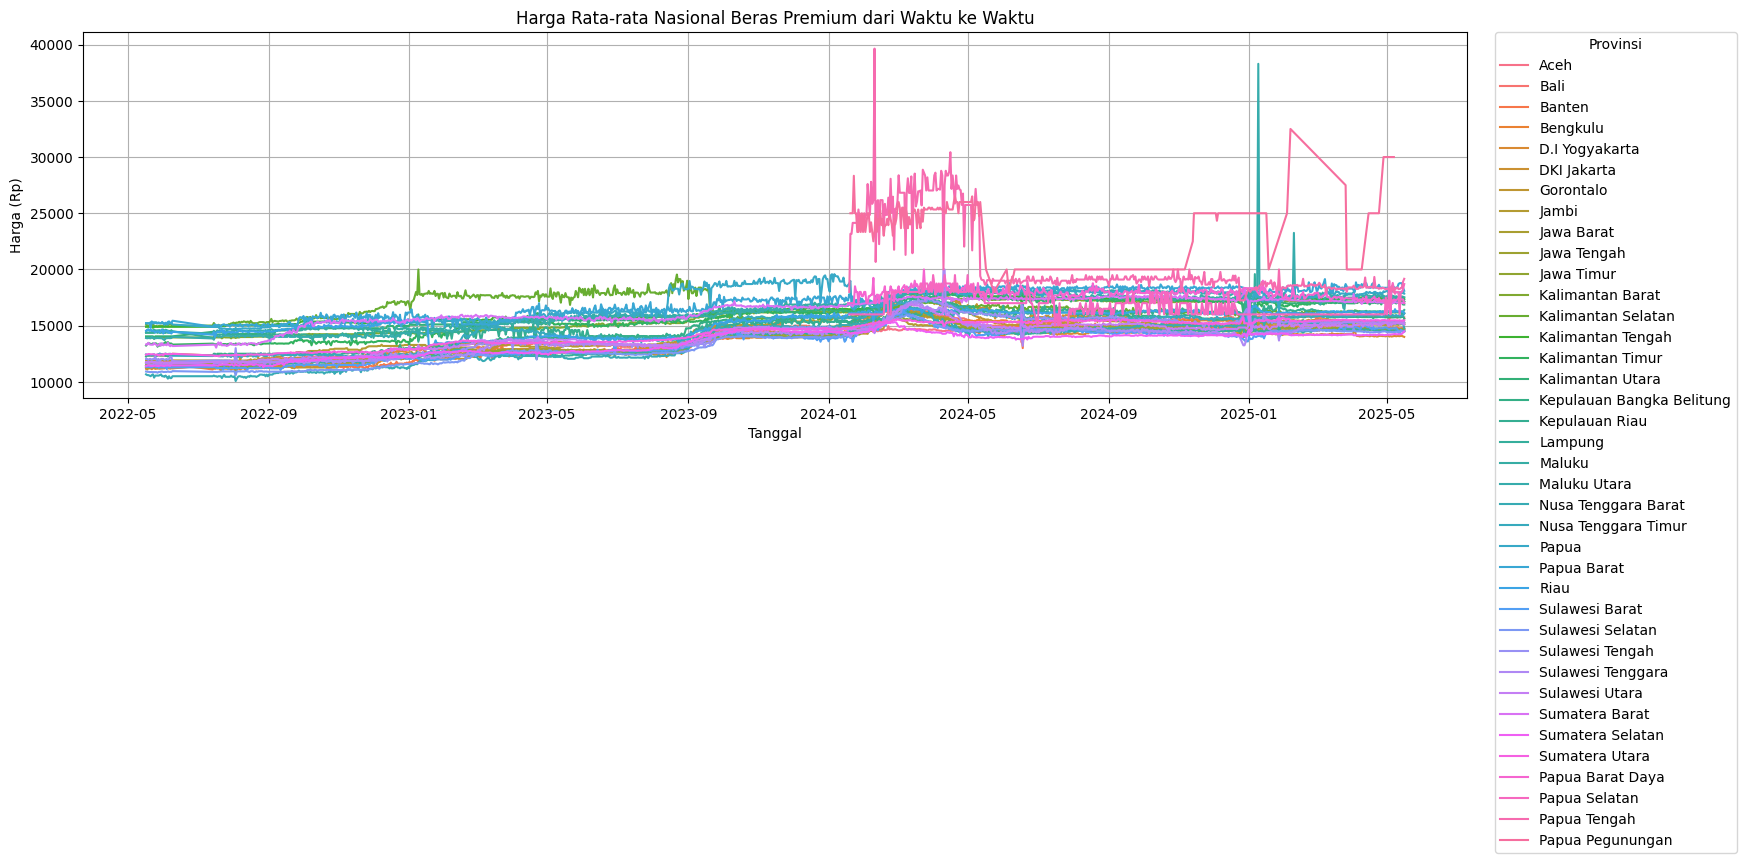

In [484]:
plt.figure(figsize=(20, 7))
sns.lineplot(x='Tanggal', y='Harga', data=df_cleaned, hue='Provinsi')
plt.title('Harga Rata-rata Nasional Beras Premium dari Waktu ke Waktu')
plt.xlabel('Tanggal')
plt.ylabel('Harga (Rp)')
plt.grid(True)
# Letakkan legenda di luar plot
plt.legend(title='Provinsi', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
# Sesuaikan layout agar legenda tidak terpotong
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()

In [485]:
# Pivot Data
df_pivot = df_cleaned.pivot(index='Tanggal', columns='Provinsi', values='Harga')
df_pivot.head(5)

Provinsi,Aceh,Bali,Banten,Bengkulu,D.I Yogyakarta,DKI Jakarta,Gorontalo,Jambi,Jawa Barat,Jawa Tengah,...,Papua Tengah,Riau,Sulawesi Barat,Sulawesi Selatan,Sulawesi Tengah,Sulawesi Tenggara,Sulawesi Utara,Sumatera Barat,Sumatera Selatan,Sumatera Utara
Tanggal,,,,,,,,,,,,,,,,,,,,,
2022-05-17,11762.0,11396.0,11163.0,11475.0,11240.0,12333.0,11258.0,11909.0,11558.0,11456.0,...,NaN,14548.0,11333.0,10918.0,12036.0,11653.0,11762.0,13320.0,11406.0,12416.0
2022-05-18,11703.0,11407.0,11186.0,11475.0,11240.0,12333.0,11092.0,11909.0,11559.0,11431.0,...,NaN,14586.0,11333.0,10895.0,12036.0,11740.0,11762.0,13317.0,11441.0,12448.0
2022-05-19,11762.0,11407.0,11286.0,11475.0,11200.0,12333.0,11250.0,11909.0,11559.0,11384.0,...,NaN,14685.0,11333.0,10895.0,11950.0,11575.0,11762.0,13472.0,11469.0,12474.0
2022-05-20,11811.0,11407.0,11225.0,11475.0,11200.0,12333.0,11258.0,11909.0,11561.0,11431.0,...,NaN,14537.0,11333.0,10873.0,12036.0,11573.0,11754.0,13332.0,11441.0,12471.0
2022-05-21,11752.0,11407.0,11225.0,11475.0,11200.0,12333.0,11275.0,11909.0,11580.0,11368.0,...,NaN,14667.0,11283.0,10873.0,12040.0,11544.0,11792.0,13312.0,11406.0,12447.0


In [486]:
# Pastikan tanggal terurut naik
df_pivot = df_pivot.sort_index()

# 1. Interpolasi linear untuk lubang di antara dua titik valid
df_interp = df_pivot.interpolate(method='linear', limit_direction='both')

# 2. Isi sisa missing di ujung (awal/akhir) dengan forward/backward fill
df_cleaned_ts_prices_only = (
    df_interp
    .fillna(method='ffill')   # isi missing di ujung bawah dengan nilai sebelumnya
    .fillna(method='bfill')   # isi missing di ujung atas dengan nilai sesudahnya
)

df_cleaned_ts_prices_only.head()

/tmp/ipykernel_9872/2525360441.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')   # isi missing di ujung bawah dengan nilai sebelumnya
/tmp/ipykernel_9872/2525360441.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')   # isi missing di ujung atas dengan nilai sesudahnya


Provinsi,Aceh,Bali,Banten,Bengkulu,D.I Yogyakarta,DKI Jakarta,Gorontalo,Jambi,Jawa Barat,Jawa Tengah,...,Papua Tengah,Riau,Sulawesi Barat,Sulawesi Selatan,Sulawesi Tengah,Sulawesi Tenggara,Sulawesi Utara,Sumatera Barat,Sumatera Selatan,Sumatera Utara
Tanggal,,,,,,,,,,,,,,,,,,,,,
2022-05-17,11762.0,11396.0,11163.0,11475.0,11240.0,12333.0,11258.0,11909.0,11558.0,11456.0,...,18000.0,14548.0,11333.0,10918.0,12036.0,11653.0,11762.0,13320.0,11406.0,12416.0
2022-05-18,11703.0,11407.0,11186.0,11475.0,11240.0,12333.0,11092.0,11909.0,11559.0,11431.0,...,18000.0,14586.0,11333.0,10895.0,12036.0,11740.0,11762.0,13317.0,11441.0,12448.0
2022-05-19,11762.0,11407.0,11286.0,11475.0,11200.0,12333.0,11250.0,11909.0,11559.0,11384.0,...,18000.0,14685.0,11333.0,10895.0,11950.0,11575.0,11762.0,13472.0,11469.0,12474.0
2022-05-20,11811.0,11407.0,11225.0,11475.0,11200.0,12333.0,11258.0,11909.0,11561.0,11431.0,...,18000.0,14537.0,11333.0,10873.0,12036.0,11573.0,11754.0,13332.0,11441.0,12471.0
2022-05-21,11752.0,11407.0,11225.0,11475.0,11200.0,12333.0,11275.0,11909.0,11580.0,11368.0,...,18000.0,14667.0,11283.0,10873.0,12040.0,11544.0,11792.0,13312.0,11406.0,12447.0


In [487]:
# Ambil data provinsi
provinsi_list = sorted(df_cleaned_ts_prices_only.columns.tolist())

# Mengubah data tiap provinsi menjadi index
provinsi_to_index = {prov: idx for idx, prov in enumerate(provinsi_list)}

print(provinsi_list)
print(f"Number of provinces (nodes): {len(provinsi_list)}")
print(provinsi_to_index)

['Aceh', 'Bali', 'Banten', 'Bengkulu', 'D.I Yogyakarta', 'DKI Jakarta', 'Gorontalo', 'Jambi', 'Jawa Barat', 'Jawa Tengah', 'Jawa Timur', 'Kalimantan Barat', 'Kalimantan Selatan', 'Kalimantan Tengah', 'Kalimantan Timur', 'Kalimantan Utara', 'Kepulauan Bangka Belitung', 'Kepulauan Riau', 'Lampung', 'Maluku', 'Maluku Utara', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur', 'Papua', 'Papua Barat', 'Papua Barat Daya', 'Papua Pegunungan', 'Papua Selatan', 'Papua Tengah', 'Riau', 'Sulawesi Barat', 'Sulawesi Selatan', 'Sulawesi Tengah', 'Sulawesi Tenggara', 'Sulawesi Utara', 'Sumatera Barat', 'Sumatera Selatan', 'Sumatera Utara']
Number of provinces (nodes): 38
{'Aceh': 0, 'Bali': 1, 'Banten': 2, 'Bengkulu': 3, 'D.I Yogyakarta': 4, 'DKI Jakarta': 5, 'Gorontalo': 6, 'Jambi': 7, 'Jawa Barat': 8, 'Jawa Tengah': 9, 'Jawa Timur': 10, 'Kalimantan Barat': 11, 'Kalimantan Selatan': 12, 'Kalimantan Tengah': 13, 'Kalimantan Timur': 14, 'Kalimantan Utara': 15, 'Kepulauan Bangka Belitung': 16, 'Kepulauan Ria

In [488]:
# Define feature engineering function
def enhance_features(df_series, col_name='Harga'):
    df = pd.DataFrame({col_name: df_series})
    df_out = pd.DataFrame(index=df.index)
    df_out[col_name] = df[col_name] # Original price
    df_out['MA7'] = df[col_name].rolling(window=7, min_periods=1).mean()
    df_out['MA30'] = df[col_name].rolling(window=30, min_periods=1).mean()
    df_out['price_change'] = df[col_name].diff().fillna(0)
    df_out['price_change_pct'] = df[col_name].pct_change().fillna(0).replace([np.inf, -np.inf], 0)
    df_out['volatility7'] = df[col_name].rolling(window=7, min_periods=1).std().fillna(0)
    return df_out

# Apply feature engineering
all_province_features_list = []
for prov_name in provinsi_list:
    province_price_series = df_cleaned_ts_prices_only[prov_name]
    enhanced_df = enhance_features(province_price_series, col_name='Harga')
    # Handle any NaNs produced by rolling/diff, especially at the beginning
    enhanced_df = enhanced_df.fillna(method='bfill').fillna(method='ffill').fillna(0) # Final fillna(0) for safety
    all_province_features_list.append(enhanced_df.values)

# Stack into a 3D numpy array: (timesteps, num_provinces, num_engineered_features)
features_np_array = np.stack(all_province_features_list, axis=1)
num_engineered_features = features_np_array.shape[2]
print(f"Shape of features_np_array: {features_np_array.shape}") # (timesteps, num_provinces, num_features)
print(f"Number of engineered features per province: {num_engineered_features}")

# Scaling: Fit scalers on the training portion of the time series data
# Determine split point in timesteps (approx. for fitting scalers)
# This should align with the timesteps that will form the training sequences
# Let's define sequence_length here as it's needed for calculating the split point for scalers
sequence_length = 30 # Must be same as used later
num_total_samples = features_np_array.shape[0] - sequence_length - 30 + 1 # 30 is prediction horizon
num_train_samples_for_scaler_fit = int(num_total_samples * 0.8)
# The last timestep index involved in the input of the last training sample
timesteps_for_scaler_fit = sequence_length + num_train_samples_for_scaler_fit -1 + sequence_length

features_np_array_scaled = np.copy(features_np_array)
scalers_province_feature = [[MinMaxScaler() for _ in range(num_engineered_features)] for _ in range(len(provinsi_list))]

for p_idx in range(len(provinsi_list)):
    for f_idx in range(num_engineered_features):
        scaler = scalers_province_feature[p_idx][f_idx]
        # Fit on the portion of data that will form training inputs
        data_to_fit = features_np_array[:timesteps_for_scaler_fit, p_idx, f_idx].reshape(-1, 1)
        if len(data_to_fit) > 0: # Ensure data is not empty
             scaler.fit(data_to_fit)
             features_np_array_scaled[:, p_idx, f_idx] = scaler.transform(features_np_array[:, p_idx, f_idx].reshape(-1, 1)).flatten()
        else: # Fallback if data_to_fit is empty (should not happen with proper setup)
             features_np_array_scaled[:, p_idx, f_idx] = 0 # Or handle as error

print(f"Shape of features_np_array_scaled: {features_np_array_scaled.shape}")
# The first feature (index 0) is 'Harga'
feature_names = ['Harga', 'MA7', 'MA30', 'price_change', 'price_change_pct', 'volatility7']
print(f"Engineered features: {feature_names}")

/tmp/ipykernel_9872/3235513023.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  enhanced_df = enhanced_df.fillna(method='bfill').fillna(method='ffill').fillna(0) # Final fillna(0) for safety
/tmp/ipykernel_9872/3235513023.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  enhanced_df = enhanced_df.fillna(method='bfill').fillna(method='ffill').fillna(0) # Final fillna(0) for safety
/tmp/ipykernel_9872/3235513023.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  enhanced_df = enhanced_df.fillna(method='bfill').fillna(method='ffill').fillna(0) # Final fillna(0) for safety
/tmp/ipykernel_9872/3235513023.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use o

Shape of features_np_array: (1062, 38, 6)
Number of engineered features per province: 6
Shape of features_np_array_scaled: (1062, 38, 6)
Engineered features: ['Harga', 'MA7', 'MA30', 'price_change', 'price_change_pct', 'volatility7']


/tmp/ipykernel_9872/3235513023.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  enhanced_df = enhanced_df.fillna(method='bfill').fillna(method='ffill').fillna(0) # Final fillna(0) for safety
/tmp/ipykernel_9872/3235513023.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  enhanced_df = enhanced_df.fillna(method='bfill').fillna(method='ffill').fillna(0) # Final fillna(0) for safety
/tmp/ipykernel_9872/3235513023.py:19: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  enhanced_df = enhanced_df.fillna(method='bfill').fillna(method='ffill').fillna(0) # Final fillna(0) for safety


In [489]:
edges = {
    'Aceh': ['Sumatera Utara'],
    'Sumatera Utara': ['Aceh', 'Sumatera Barat', 'Riau'],
    'Sumatera Barat': ['Sumatera Utara', 'Riau', 'Jambi'],
    'Riau': ['Sumatera Utara', 'Sumatera Barat', 'Jambi', 'Kepulauan Riau'],
    'Kepulauan Riau': ['Riau'],
    'Jambi': ['Sumatera Barat', 'Riau', 'Sumatera Selatan', 'Bengkulu'],
    'Bengkulu': ['Sumatera Barat', 'Jambi', 'Sumatera Selatan', 'Lampung'],
    'Sumatera Selatan': ['Jambi', 'Bengkulu', 'Lampung', 'Kepulauan Bangka Belitung'],
    'Kepulauan Bangka Belitung': ['Sumatera Selatan'],
    'Lampung': ['Bengkulu', 'Sumatera Selatan', 'Banten'],
    'DKI Jakarta': ['Banten', 'Jawa Barat'],
    'Jawa Barat': ['DKI Jakarta', 'Banten', 'Jawa Tengah'],
    'Banten': ['Lampung', 'DKI Jakarta', 'Jawa Barat'],
    'Jawa Tengah': ['Jawa Barat', 'D.I Yogyakarta', 'Jawa Timur'],
    'D.I Yogyakarta': ['Jawa Tengah', 'Jawa Timur'],
    'Jawa Timur': ['Jawa Tengah', 'D.I Yogyakarta', 'Bali'],
    'Bali': ['Jawa Timur', 'Nusa Tenggara Barat'],
    'Nusa Tenggara Barat': ['Bali', 'Nusa Tenggara Timur'],
    'Nusa Tenggara Timur': ['Nusa Tenggara Barat'],
    'Kalimantan Barat': ['Kalimantan Tengah'],
    'Kalimantan Tengah': ['Kalimantan Barat', 'Kalimantan Selatan', 'Kalimantan Timur'],
    'Kalimantan Selatan': ['Kalimantan Tengah', 'Kalimantan Timur'],
    'Kalimantan Timur': ['Kalimantan Tengah', 'Kalimantan Selatan', 'Kalimantan Utara'],
    'Kalimantan Utara': ['Kalimantan Timur'],
    'Sulawesi Utara': ['Gorontalo'],
    'Gorontalo': ['Sulawesi Utara', 'Sulawesi Tengah'],
    'Sulawesi Tengah': ['Gorontalo', 'Sulawesi Barat', 'Sulawesi Selatan', 'Sulawesi Tenggara'],
    'Sulawesi Barat': ['Sulawesi Tengah', 'Sulawesi Selatan'],
    'Sulawesi Selatan': ['Sulawesi Tengah', 'Sulawesi Barat', 'Sulawesi Tenggara'],
    'Sulawesi Tenggara': ['Sulawesi Tengah', 'Sulawesi Selatan'],
    'Maluku': ['Maluku Utara'],
    'Maluku Utara': ['Maluku'],
    'Papua Barat': ['Papua'],
    'Papua': ['Papua Barat', 'Papua Pegunungan', 'Papua Selatan', 'Papua Tengah'],
    'Papua Pegunungan': ['Papua', 'Papua Tengah'],
    'Papua Selatan': ['Papua', 'Papua Tengah'],
    'Papua Tengah': ['Papua', 'Papua Pegunungan', 'Papua Selatan'],
    'Papua Barat Daya': ['Papua Barat']
}

In [490]:
# List kosong untuk menampung index
edge_index = []

# Untuk setiap data dari edges akan dikonversi menjadi index yang ada di dictionary provinsi_to_index
for src, destinations in edges.items():
    for dst in destinations:
        i, j = provinsi_to_index[src], provinsi_to_index[dst]
        edge_index.append((i, j))
        edge_index.append((j, i))  # graf tidak berarah

import torch
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

print(f"Created edge_index tensor of shape: {edge_index.shape}")
print(f"Number of edges: {edge_index.shape[1]}")

Created edge_index tensor of shape: torch.Size([2, 176])
Number of edges: 176


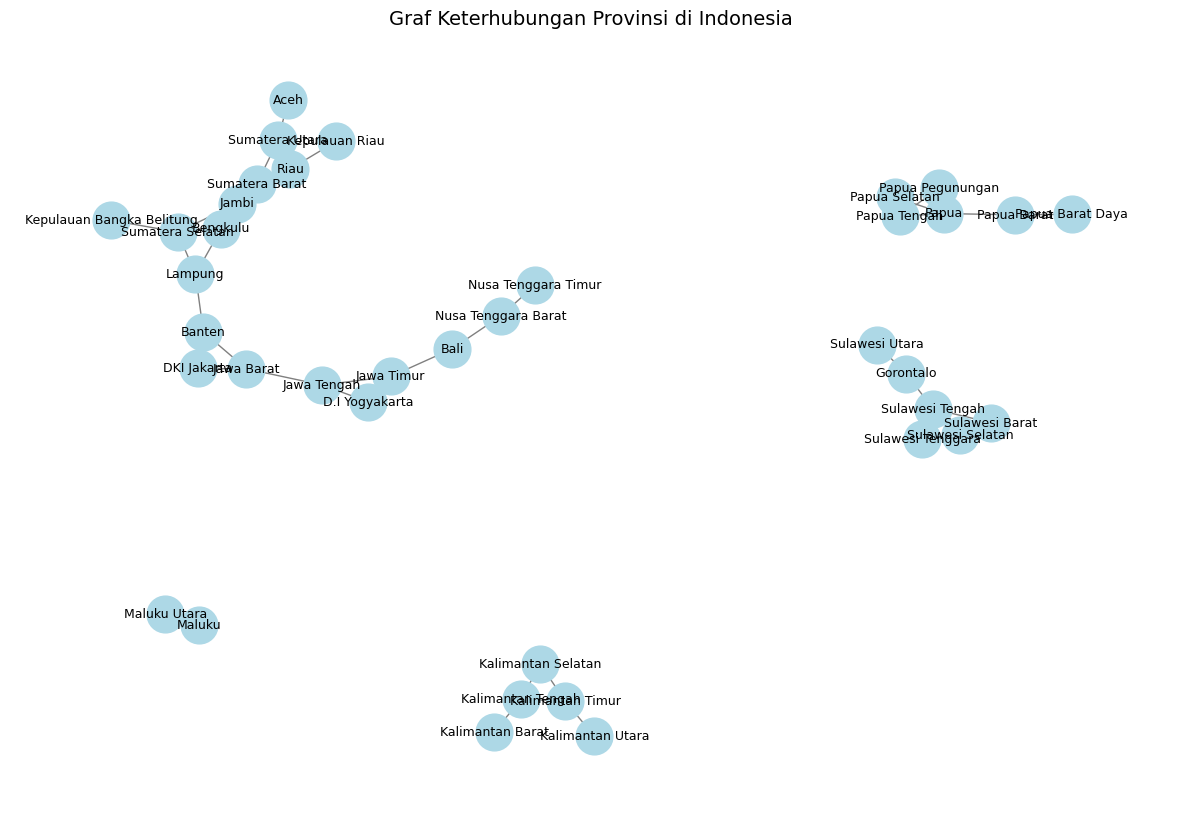

In [491]:
import networkx as nx
# Buat graf kosong
G = nx.Graph()

# Tambahkan node
G.add_nodes_from(provinsi_to_index.keys())

# Convert edges dictionary to a list of tuples (source, destination) for NetworkX
edge_list = []
for src, destinations in edges.items():
    for dst in destinations:
        edge_list.append((src, dst))

# Tambahkan edge menggunakan list edge yang telah dibuat
G.add_edges_from(edge_list)

# Layout graf (gunakan spring layout agar terlihat rapi)
pos = nx.spring_layout(G, seed=42)  # bisa juga pakai nx.kamada_kawai_layout(G)

# Plot graf
plt.figure(figsize=(15, 10))
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
nx.draw_networkx_edges(G, pos, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=9, font_family='sans-serif')

plt.title("Graf Keterhubungan Provinsi di Indonesia", fontsize=14)
plt.axis('off')
plt.show()

In [492]:
# sequence_length = 30 # Defined in the new feature engineering cell
prediction_horizon = 30
X_list = []
y_list = []

# Use features_np_array_scaled from the new feature engineering cell
# features_np_array_scaled has shape (timesteps, num_provinces, num_engineered_features)

for i in range(sequence_length, features_np_array_scaled.shape[0] - prediction_horizon + 1):
    # Input features: (num_provinces, sequence_length * num_engineered_features)
    x_sample_data = features_np_array_scaled[i-sequence_length:i, :, :]  # Shape: (seq_len, num_prov, num_feat)
    # Transpose to (num_prov, seq_len, num_feat) then reshape
    x_reshaped = x_sample_data.transpose(1, 0, 2).reshape(len(provinsi_list), -1)
    X_list.append(x_reshaped)

    # Target: Next 'prediction_horizon' days of the 'Harga' feature (index 0)
    # Shape: (num_provinces, prediction_horizon)
    y_sample_data = features_np_array_scaled[i:i+prediction_horizon, :, 0]  # Target is 0-th feature (Price), scaled. Shape: (pred_hor, num_prov)
    y_reshaped = y_sample_data.T  # Shape: (num_prov, pred_hor)
    y_list.append(y_reshaped)

X = np.stack(X_list)  # Shape: (samples, num_provinces, sequence_length * num_engineered_features)
y = np.stack(y_list)      # Shape: (samples, num_provinces, prediction_horizon)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}") # Ensure this prints a 3D shape, e.g., (num_samples, 38, 30)

# The old scaling logic from cell f987bee0 is now handled before this cell.
# So, X and y are already scaled.

X shape: (1003, 38, 180)
y shape: (1003, 38, 30)


In [493]:
# This cell's original scaling logic has been moved and integrated 
# into the new feature engineering cell ("new_feature_engineering_cell")
# and the sequence creation cell ("718a3ba8") now uses the pre-scaled data.
# X and y are now already scaled.

# We can print shapes again to confirm
print(f"X shape after sequence creation (should be scaled): {X.shape}")
print(f"y shape after sequence creation (should be scaled): {y.shape}")

# The scalers are now stored in `scalers_province_feature` 
# from the "new_feature_engineering_cell".
# `scalers_province_feature[province_idx][feature_idx]`
# For unscaling predictions (which are prices, i.e., feature_idx=0):
# `scalers_province_feature[province_idx][0]` will be used.

X shape after sequence creation (should be scaled): (1003, 38, 180)
y shape after sequence creation (should be scaled): (1003, 38, 30)


In [494]:
gnn_dataset = []
# X has shape (samples, num_provinces, sequence_length * num_engineered_features)
# y has shape (samples, num_provinces, prediction_horizon)

# Diagnostic check:
if not (X.ndim == 3 and y.ndim == 3 and X.shape[0] == y.shape[0] and X.shape[1] == y.shape[1] and y.shape[2] == prediction_horizon):
    error_msg = (
        f"X and y shape mismatch or unexpected dimensions!\n"
        f"X shape: {X.shape}, y shape: {y.shape}\n"
        f"Expected X: (num_samples, num_provinces, features_per_node)\n"
        f"Expected y: (num_samples, num_provinces, prediction_horizon={prediction_horizon})\n"
        f"Number of samples (X.shape[0]={X.shape[0]}) should match (y.shape[0]={y.shape[0]}).\n"
        "Please ensure the cell that creates X and y (Cell 15) was run correctly and variables are not stale or overwritten."
    )
    raise ValueError(error_msg)

for i in range(X.shape[0]):
    # x_node_features: (num_nodes, sequence_length * num_engineered_features)
    x_node_features = torch.tensor(X[i], dtype=torch.float) 
    # y_target_node: (num_nodes, prediction_horizon)
    y_target_node = torch.tensor(y[i], dtype=torch.float)  
    
    data = Data(x=x_node_features, edge_index=edge_index, y=y_target_node)
    gnn_dataset.append(data)

print(f"Number of GNN data samples: {len(gnn_dataset)}")
if len(gnn_dataset) > 0:
    print(f"Example GNN data sample: {gnn_dataset[0]}")
    print(f"Shape of x in sample: {gnn_dataset[0].x.shape}")
    print(f"Shape of y in sample: {gnn_dataset[0].y.shape}")

Number of GNN data samples: 1003
Example GNN data sample: Data(x=[38, 180], edge_index=[2, 176], y=[38, 30])
Shape of x in sample: torch.Size([38, 180])
Shape of y in sample: torch.Size([38, 30])


## Membuat Dataset Temporal untuk Temporal GNN

Kita akan membentuk dataset temporal, di mana setiap snapshot merepresentasikan satu hari, dan labelnya adalah harga 30 hari ke depan.

In [495]:
from torch_geometric.data import TemporalData

temporal_dataset = []
# features_np_array_scaled has shape (timesteps, num_provinces, num_engineered_features)
# sequence_length and prediction_horizon are defined

for i in range(sequence_length, features_np_array_scaled.shape[0] - prediction_horizon + 1):
    # Fitur node: (num_nodes, sequence_length * num_engineered_features)
    x_sample_data = features_np_array_scaled[i-sequence_length:i, :, :]
    x_node_features = torch.tensor(x_sample_data.transpose(1,0,2).reshape(len(provinsi_list), -1), dtype=torch.float)
    
    edge_idx = edge_index # Edge index tetap sama

    # Target: harga (0-th feature) 30 hari ke depan (untuk semua provinsi)
    # (num_nodes, prediction_horizon)
    y_sample_data = features_np_array_scaled[i:i+prediction_horizon, :, 0] # Target is 0-th feature (Price), scaled
    y_target_node = torch.tensor(y_sample_data.T, dtype=torch.float)
    
    t = torch.tensor([i], dtype=torch.long) # Time step
    
    td = TemporalData(x=x_node_features, edge_index=edge_idx, y=y_target_node, t=t)
    temporal_dataset.append(td)

print(f"Total snapshot temporal: {len(temporal_dataset)}")
if len(temporal_dataset) > 0:
    print("Contoh snapshot temporal:", temporal_dataset[0])
    print(f"Shape of x in temporal snapshot: {temporal_dataset[0].x.shape}")
    print(f"Shape of y in temporal snapshot: {temporal_dataset[0].y.shape}")

Total snapshot temporal: 1003
Contoh snapshot temporal: TemporalData(t=[1], x=[38, 180], edge_index=[2, 176], y=[38, 30])
Shape of x in temporal snapshot: torch.Size([38, 180])
Shape of y in temporal snapshot: torch.Size([38, 30])


In [496]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
# from sklearn.preprocessing import RobustScaler # Unused import
import pandas as pd
import numpy as np
import optuna

class ImprovedGNNPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels=128, out_channels=30, num_layers=3, dropout=0.15): # out_channels is prediction_horizon
        super().__init__()
        self.layers = nn.ModuleList()
        # Adjust in_channels based on sequence_length * num_engineered_features
        self.layers.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2): # Corrected loop for num_layers
            self.layers.append(GCNConv(hidden_channels, hidden_channels))
        if num_layers > 1: # Ensure last GCNConv is added if num_layers > 1
            self.layers.append(GCNConv(hidden_channels, hidden_channels))
        elif num_layers == 1: # If only one layer, it's already added. This handles GCN(in, out) if hidden_channels=out_channels
             pass


        self.layer_norms = nn.ModuleList([nn.LayerNorm(hidden_channels) for _ in range(num_layers)])
        # BatchNorm1d expects (N, C) or (N, C, L), GCNConv output is (num_nodes, hidden_channels)
        self.batchnorms = nn.ModuleList([nn.BatchNorm1d(hidden_channels) for _ in range(num_layers)])
        self.relu = nn.ReLU()
        self.dropout_layer = nn.Dropout(dropout) # Renamed from self.dropout to avoid conflict

        self.temporal_attention = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2), # Reduced complexity slightly
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, 1),
            nn.Sigmoid() # Ensure attention weights are between 0 and 1
        )
        self.mlp = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels // 2), # MLP to map to output
            nn.ReLU(),
            nn.Dropout(dropout), # Use the passed dropout value
            nn.Linear(hidden_channels // 2, out_channels)
        )

        # GRU expects input of shape (batch, seq, feature) or (seq, batch, feature)
        # GCN output is (num_nodes, hidden_channels). We treat num_nodes as batch for GRU here.
        # Or, if we want to process features over time for each node:
        # Input to GRU should be (num_nodes, num_gcn_layers_or_some_sequence, hidden_channels)
        # Current GRU processes the output of GCN layers as if num_nodes is batch size and 1 is seq_len
        self.gru = nn.GRU(hidden_channels, hidden_channels, num_layers=1, batch_first=True) # num_layers for GRU can be tuned

    def forward(self, x, edge_index):
        # x shape: (num_nodes, in_channels = sequence_length * num_engineered_features)
        h = x
        
        # Store hidden states from GCN layers if we want to feed a sequence to GRU
        # For now, let's assume GRU processes the final GCN output
        
        for i in range(len(self.layers)):
            layer = self.layers[i]
            norm = self.layer_norms[i]
            bn = self.batchnorms[i]

            h_prev = h
            h = layer(h, edge_index)
            h = norm(h) 
            if h.shape[0] > 1: # BatchNorm1d requires batch size > 1
                h = bn(h)
            h = self.relu(h)
            h = self.dropout_layer(h)
            
            if i > 0 and h_prev.shape == h.shape : # Residual connection if shapes match (after first layer)
                h = h + h_prev
            
        # GRU input: (batch_size=num_nodes, seq_len=1, input_size=hidden_channels)
        h_gru_input = h.unsqueeze(1) 
        h_gru_out, _ = self.gru(h_gru_input)
        h = h_gru_out.squeeze(1) # Back to (num_nodes, hidden_channels)

        attn_weights = self.temporal_attention(h) 
        h_attended = h * attn_weights # Element-wise multiplication (gating)
        
        return self.mlp(h_attended)

In [497]:
# The enhance_features function was moved to an earlier cell.
# This train_model function will be used for the final training after Optuna.
def train_model(model, train_loader, val_loader, epochs=150, patience=10, learning_rate=1e-3, weight_decay=1e-5):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
    mse_crit = nn.MSELoss()
    mae_crit = nn.L1Loss()
    
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_state = None
    patience_count = 0
    
    for e in range(epochs):
        model.train()
        total_train_loss = 0
        n_train_batches = 0
        
        for batch in train_loader:
            optimizer.zero_grad()
            pred = model(batch.x, batch.edge_index)
            # Ensure batch.y has the same shape as pred for loss calculation
            # pred shape: (batch_nodes, out_channels), batch.y shape: (batch_nodes, out_channels)
            loss = 0.7 * mse_crit(pred, batch.y) + 0.3 * mae_crit(pred, batch.y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_train_loss += loss.item()
            n_train_batches += 1
            
        avg_train_loss = total_train_loss / n_train_batches if n_train_batches > 0 else float('inf')
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        total_val_loss = 0
        n_val_batches = 0
        with torch.no_grad():
            for batch in val_loader:
                pred = model(batch.x, batch.edge_index)
                val_loss = mse_crit(pred, batch.y) # Using MSE for validation tracking
                total_val_loss += val_loss.item()
                n_val_batches += 1
                
        avg_val_loss = total_val_loss / n_val_batches if n_val_batches > 0 else float('inf')
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss) # Pass validation loss to schedulers like ReduceLROnPlateau
                                     # For CosineAnnealing, it steps based on epochs/iterations
        
        print(f"Epoch {e+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, LR: {optimizer.param_groups[0]['lr']:.6e}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            patience_count = 0
            print(f"New best validation loss: {best_val_loss:.6f}. Saving model.")
        else:
            patience_count += 1
            if patience_count >= patience:
                print(f"Early stopping triggered at epoch {e+1} due to no improvement for {patience} epochs.")
                break
            
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Loaded best model state.")
        
    return train_losses, val_losses, best_val_loss

In [498]:
# Define train_dataset and val_dataset before the objective function
split_train_gnn = int(len(gnn_dataset)*0.8) 
split_val_gnn = int(len(gnn_dataset)*0.9)
train_dataset = gnn_dataset[:split_train_gnn]
val_dataset = gnn_dataset[split_train_gnn:split_val_gnn]
test_dataset = gnn_dataset[split_val_gnn:]

# Ensure sequence_length and num_engineered_features are available globally or passed
# These should be defined from "new_feature_engineering_cell"
# sequence_length = 30 (defined earlier)
# num_engineered_features = features_np_array.shape[2] (defined in "new_feature_engineering_cell")
model_in_channels = sequence_length * num_engineered_features
model_out_channels = prediction_horizon # which is 30

def objective(trial):
    params = {
        'hidden_channels': trial.suggest_int('hidden_channels', 64, 256, step=32), # Wider range, steps
        'num_layers': trial.suggest_int('num_layers', 2, 4), # More layers
        'dropout': trial.suggest_float('dropout', 0.1, 0.5, step=0.05), # Adjusted range
        'learning_rate': trial.suggest_loguniform('learning_rate', 5e-5, 5e-3), # Wider range
        'weight_decay': trial.suggest_loguniform('weight_decay', 1e-6, 1e-3),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128, 256]) # Larger batch sizes
    }

    model = ImprovedGNNPredictor(
        in_channels=model_in_channels, 
        hidden_channels=params['hidden_channels'],
        num_layers=params['num_layers'],
        dropout=params['dropout'],
        out_channels=model_out_channels
    )

    optimizer = torch.optim.AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    mse = nn.MSELoss() # Use MSE for Optuna's objective value, as it's common for regression.
    mae = nn.L1Loss()

    train_loader_optuna = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=2, pin_memory=True)
    val_loader_optuna = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=2, pin_memory=True)

    best_val_loss_trial = float('inf')
    patience_optuna = 7 # Patience for Optuna trials
    patience_counter_optuna = 0
    optuna_epochs = 60 # Max epochs for an Optuna trial

    for epoch in range(optuna_epochs):
        model.train()
        epoch_train_loss = 0
        for batch_idx, batch in enumerate(train_loader_optuna):
            optimizer.zero_grad()
            pred = model(batch.x, batch.edge_index)
            loss = 0.7 * mse(pred, batch.y) + 0.3 * mae(pred, batch.y) # Combined loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            epoch_train_loss += loss.item()
        
        avg_train_loss_epoch = epoch_train_loss / len(train_loader_optuna) if len(train_loader_optuna) > 0 else float('inf')

        model.eval()
        current_val_loss_trial = 0
        with torch.no_grad():
            for batch in val_loader_optuna:
                pred = model(batch.x, batch.edge_index)
                current_val_loss_trial += mse(pred, batch.y).item() # Track MSE for Optuna objective
        
        avg_val_loss_epoch = current_val_loss_trial / len(val_loader_optuna) if len(val_loader_optuna) > 0 else float('inf')
        
        trial.report(avg_val_loss_epoch, epoch)

        if avg_val_loss_epoch < best_val_loss_trial:
            best_val_loss_trial = avg_val_loss_epoch
            patience_counter_optuna = 0
        else:
            patience_counter_optuna += 1
        
        if trial.should_prune() or patience_counter_optuna >= patience_optuna:
            if patience_counter_optuna >= patience_optuna:
                 print(f"Trial {trial.number} early stopping at epoch {epoch+1}. Best val loss: {best_val_loss_trial:.6f}")
            else:
                 print(f"Trial {trial.number} pruned at epoch {epoch+1}.")
            # Return the best validation loss achieved in this pruned/stopped trial
            # If no improvement was ever made, best_val_loss_trial could still be inf.
            # Optuna handles TrialPruned exception by returning the last reported value or a special value.
            # To be explicit, we can return the best loss found so far.
            if best_val_loss_trial == float('inf') and avg_val_loss_epoch != float('inf'): # if first epoch was bad
                return avg_val_loss_epoch # return current if best is still inf
            return best_val_loss_trial


        if epoch % 10 == 0: # Optional: print progress within a trial
            print(f"Trial {trial.number}, Epoch {epoch+1}, Train Loss: {avg_train_loss_epoch:.6f}, Val Loss: {avg_val_loss_epoch:.6f}")


    return best_val_loss_trial

study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(objective, n_trials=70, show_progress_bar=True, n_jobs=1) # n_jobs=-1 for parallel if env supports

best_params = study.best_params
print("Best hyperparameters found by Optuna:", best_params)
print(f"Best validation loss during Optuna search: {study.best_value:.6f}")

# Save best_params to use them for the final model training
import json
with open('best_gnn_params.json', 'w') as f:
    json.dump(best_params, f)

[I 2025-06-12 00:44:34,664] A new study created in memory with name: no-name-32a9d505-1909-4c83-9ebd-89ede253ec40
  0%|          | 0/70 [00:00<?, ?it/s]/tmp/ipykernel_9872/1499972449.py:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 5e-5, 5e-3), # Wider range
/tmp/ipykernel_9872/1499972449.py:21: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'weight_decay': trial.suggest_loguniform('weight_decay', 1e-6, 1e-3),
/home/abijaksana/Universitas Hasanuddin/Semester IV/Data Mining/prediksi_harga_pangan/env/lib64/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, 

Trial 0, Epoch 1, Train Loss: 0.136924, Val Loss: 0.069165
Trial 0, Epoch 11, Train Loss: 0.035527, Val Loss: 0.025355
Trial 0, Epoch 11, Train Loss: 0.035527, Val Loss: 0.025355
Trial 0, Epoch 21, Train Loss: 0.027840, Val Loss: 0.014153
Trial 0, Epoch 21, Train Loss: 0.027840, Val Loss: 0.014153
Trial 0, Epoch 31, Train Loss: 0.022519, Val Loss: 0.012818
Trial 0, Epoch 31, Train Loss: 0.022519, Val Loss: 0.012818


Best trial: 0. Best value: 0.0128181:   1%|▏         | 1/70 [01:00<1:09:10, 60.16s/it]

Trial 0 early stopping at epoch 38. Best val loss: 0.012818
[I 2025-06-12 00:45:34,819] Trial 0 finished with value: 0.012818066170439124 and parameters: {'hidden_channels': 160, 'num_layers': 4, 'dropout': 0.2, 'learning_rate': 0.0035853980381324994, 'weight_decay': 5.53215484384645e-05, 'batch_size': 64}. Best is trial 0 with value: 0.012818066170439124.
Trial 1, Epoch 1, Train Loss: 0.285030, Val Loss: 0.290800
Trial 1, Epoch 1, Train Loss: 0.285030, Val Loss: 0.290800
Trial 1, Epoch 11, Train Loss: 0.044552, Val Loss: 0.027984
Trial 1, Epoch 11, Train Loss: 0.044552, Val Loss: 0.027984
Trial 1, Epoch 21, Train Loss: 0.035127, Val Loss: 0.023101
Trial 1, Epoch 21, Train Loss: 0.035127, Val Loss: 0.023101
Trial 1, Epoch 31, Train Loss: 0.031897, Val Loss: 0.018234
Trial 1, Epoch 31, Train Loss: 0.031897, Val Loss: 0.018234


Best trial: 0. Best value: 0.0128181:   3%|▎         | 2/70 [01:30<48:34, 42.86s/it]  

Trial 1 early stopping at epoch 39. Best val loss: 0.014957
[I 2025-06-12 00:46:05,572] Trial 1 finished with value: 0.014956883154809475 and parameters: {'hidden_channels': 64, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.002964411661204154, 'weight_decay': 7.3465879334425555e-06, 'batch_size': 128}. Best is trial 0 with value: 0.012818066170439124.
Trial 2, Epoch 1, Train Loss: 0.238630, Val Loss: 0.089905
Trial 2, Epoch 1, Train Loss: 0.238630, Val Loss: 0.089905
Trial 2, Epoch 11, Train Loss: 0.052932, Val Loss: 0.045047
Trial 2, Epoch 11, Train Loss: 0.052932, Val Loss: 0.045047
Trial 2, Epoch 21, Train Loss: 0.044978, Val Loss: 0.026164
Trial 2, Epoch 21, Train Loss: 0.044978, Val Loss: 0.026164
Trial 2, Epoch 31, Train Loss: 0.040778, Val Loss: 0.030094
Trial 2, Epoch 31, Train Loss: 0.040778, Val Loss: 0.030094


Best trial: 0. Best value: 0.0128181:   4%|▍         | 3/70 [02:08<45:00, 40.31s/it]

Trial 2 early stopping at epoch 33. Best val loss: 0.025253
[I 2025-06-12 00:46:42,840] Trial 2 finished with value: 0.025253351777791977 and parameters: {'hidden_channels': 160, 'num_layers': 2, 'dropout': 0.45000000000000007, 'learning_rate': 0.0027734494981326335, 'weight_decay': 2.0129471749538854e-06, 'batch_size': 128}. Best is trial 0 with value: 0.012818066170439124.
Trial 3, Epoch 1, Train Loss: 0.326025, Val Loss: 0.463609
Trial 3, Epoch 1, Train Loss: 0.326025, Val Loss: 0.463609
Trial 3, Epoch 11, Train Loss: 0.093464, Val Loss: 0.044132
Trial 3, Epoch 11, Train Loss: 0.093464, Val Loss: 0.044132
Trial 3, Epoch 21, Train Loss: 0.071018, Val Loss: 0.031039
Trial 3, Epoch 21, Train Loss: 0.071018, Val Loss: 0.031039
Trial 3, Epoch 31, Train Loss: 0.061438, Val Loss: 0.029302
Trial 3, Epoch 31, Train Loss: 0.061438, Val Loss: 0.029302
Trial 3, Epoch 41, Train Loss: 0.057847, Val Loss: 0.028028
Trial 3, Epoch 41, Train Loss: 0.057847, Val Loss: 0.028028


Best trial: 0. Best value: 0.0128181:   6%|▌         | 4/70 [03:01<49:56, 45.40s/it]

Trial 3 early stopping at epoch 45. Best val loss: 0.027823
[I 2025-06-12 00:47:36,037] Trial 3 finished with value: 0.027823418378829956 and parameters: {'hidden_channels': 160, 'num_layers': 2, 'dropout': 0.45000000000000007, 'learning_rate': 0.0005382278615694817, 'weight_decay': 2.0033175351842484e-06, 'batch_size': 256}. Best is trial 0 with value: 0.012818066170439124.
Trial 4, Epoch 1, Train Loss: 0.168952, Val Loss: 0.125515
Trial 4, Epoch 1, Train Loss: 0.168952, Val Loss: 0.125515
Trial 4, Epoch 11, Train Loss: 0.040619, Val Loss: 0.025201
Trial 4, Epoch 11, Train Loss: 0.040619, Val Loss: 0.025201
Trial 4, Epoch 21, Train Loss: 0.032611, Val Loss: 0.028703
Trial 4, Epoch 21, Train Loss: 0.032611, Val Loss: 0.028703
Trial 4, Epoch 31, Train Loss: 0.024200, Val Loss: 0.014611
Trial 4, Epoch 31, Train Loss: 0.024200, Val Loss: 0.014611
Trial 4, Epoch 41, Train Loss: 0.022304, Val Loss: 0.017218
Trial 4, Epoch 41, Train Loss: 0.022304, Val Loss: 0.017218


Best trial: 4. Best value: 0.0118121:   7%|▋         | 5/70 [04:24<1:03:44, 58.84s/it]

Trial 4 early stopping at epoch 46. Best val loss: 0.011812
[I 2025-06-12 00:48:58,724] Trial 4 finished with value: 0.011812135577201843 and parameters: {'hidden_channels': 224, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.0031238745580067532, 'weight_decay': 2.3684356865902817e-06, 'batch_size': 128}. Best is trial 4 with value: 0.011812135577201843.
Trial 5, Epoch 1, Train Loss: 0.313310, Val Loss: 0.462886
Trial 5, Epoch 1, Train Loss: 0.313310, Val Loss: 0.462886


Best trial: 4. Best value: 0.0118121:   9%|▊         | 6/70 [04:47<49:53, 46.77s/it]  

Trial 5 pruned at epoch 11.
[I 2025-06-12 00:49:22,048] Trial 5 finished with value: 0.15308979153633118 and parameters: {'hidden_channels': 160, 'num_layers': 4, 'dropout': 0.5, 'learning_rate': 0.00010458341757141439, 'weight_decay': 8.190709444459937e-06, 'batch_size': 256}. Best is trial 4 with value: 0.011812135577201843.
Trial 6, Epoch 1, Train Loss: 0.130445, Val Loss: 0.067493
Trial 6, Epoch 1, Train Loss: 0.130445, Val Loss: 0.067493
Trial 6, Epoch 11, Train Loss: 0.036939, Val Loss: 0.026944
Trial 6, Epoch 11, Train Loss: 0.036939, Val Loss: 0.026944
Trial 6, Epoch 21, Train Loss: 0.030723, Val Loss: 0.022728
Trial 6, Epoch 21, Train Loss: 0.030723, Val Loss: 0.022728


Best trial: 4. Best value: 0.0118121:  10%|█         | 7/70 [05:34<49:03, 46.72s/it]

Trial 6 pruned at epoch 24.
[I 2025-06-12 00:50:08,670] Trial 6 finished with value: 0.019470337312668562 and parameters: {'hidden_channels': 192, 'num_layers': 3, 'dropout': 0.35, 'learning_rate': 0.004089283755561938, 'weight_decay': 5.4135726609749774e-05, 'batch_size': 64}. Best is trial 4 with value: 0.011812135577201843.
Trial 7, Epoch 1, Train Loss: 0.182692, Val Loss: 0.084348
Trial 7, Epoch 1, Train Loss: 0.182692, Val Loss: 0.084348
Trial 7, Epoch 11, Train Loss: 0.045913, Val Loss: 0.036510
Trial 7, Epoch 11, Train Loss: 0.045913, Val Loss: 0.036510
Trial 7, Epoch 21, Train Loss: 0.035432, Val Loss: 0.018864
Trial 7, Epoch 21, Train Loss: 0.035432, Val Loss: 0.018864


Best trial: 4. Best value: 0.0118121:  11%|█▏        | 8/70 [06:17<47:14, 45.72s/it]

Trial 7 early stopping at epoch 29. Best val loss: 0.018231
[I 2025-06-12 00:50:52,247] Trial 7 finished with value: 0.01823060866445303 and parameters: {'hidden_channels': 128, 'num_layers': 4, 'dropout': 0.30000000000000004, 'learning_rate': 0.002285904660564773, 'weight_decay': 1.0026103037322749e-05, 'batch_size': 64}. Best is trial 4 with value: 0.011812135577201843.
Trial 8, Epoch 1, Train Loss: 0.226476, Val Loss: 0.109971
Trial 8, Epoch 1, Train Loss: 0.226476, Val Loss: 0.109971
Trial 8, Epoch 11, Train Loss: 0.046279, Val Loss: 0.030866
Trial 8, Epoch 11, Train Loss: 0.046279, Val Loss: 0.030866


Best trial: 4. Best value: 0.0118121:  13%|█▎        | 9/70 [06:33<37:04, 36.46s/it]

Trial 8 pruned at epoch 13.
[I 2025-06-12 00:51:08,355] Trial 8 finished with value: 0.025907528586685658 and parameters: {'hidden_channels': 96, 'num_layers': 4, 'dropout': 0.25, 'learning_rate': 0.0014836994108256617, 'weight_decay': 0.0006887518424220538, 'batch_size': 64}. Best is trial 4 with value: 0.011812135577201843.
Trial 9, Epoch 1, Train Loss: 0.341757, Val Loss: 0.481383
Trial 9, Epoch 1, Train Loss: 0.341757, Val Loss: 0.481383


Best trial: 4. Best value: 0.0118121:  14%|█▍        | 10/70 [06:51<30:36, 30.61s/it]

Trial 9 pruned at epoch 11.
[I 2025-06-12 00:51:25,854] Trial 9 finished with value: 0.12869606912136078 and parameters: {'hidden_channels': 128, 'num_layers': 4, 'dropout': 0.45000000000000007, 'learning_rate': 5.797529262344702e-05, 'weight_decay': 3.418059169567749e-06, 'batch_size': 64}. Best is trial 4 with value: 0.011812135577201843.
Trial 10, Epoch 1, Train Loss: 0.135184, Val Loss: 0.055127
Trial 10, Epoch 1, Train Loss: 0.135184, Val Loss: 0.055127
Trial 10, Epoch 11, Train Loss: 0.038754, Val Loss: 0.056727
Trial 10, Epoch 11, Train Loss: 0.038754, Val Loss: 0.056727
Trial 10, Epoch 21, Train Loss: 0.030757, Val Loss: 0.025961
Trial 10, Epoch 21, Train Loss: 0.030757, Val Loss: 0.025961
Trial 10, Epoch 31, Train Loss: 0.026536, Val Loss: 0.022815
Trial 10, Epoch 31, Train Loss: 0.026536, Val Loss: 0.022815
Trial 10, Epoch 41, Train Loss: 0.020662, Val Loss: 0.013930
Trial 10, Epoch 41, Train Loss: 0.020662, Val Loss: 0.013930


Best trial: 4. Best value: 0.0118121:  16%|█▌        | 11/70 [08:45<55:11, 56.12s/it]

Trial 10 pruned at epoch 46.
[I 2025-06-12 00:53:19,821] Trial 10 finished with value: 0.013373994617722929 and parameters: {'hidden_channels': 256, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.0007146335652921399, 'weight_decay': 0.0003632788194235257, 'batch_size': 32}. Best is trial 4 with value: 0.011812135577201843.
Trial 11, Epoch 1, Train Loss: 0.233026, Val Loss: 0.079512
Trial 11, Epoch 1, Train Loss: 0.233026, Val Loss: 0.079512
Trial 11, Epoch 11, Train Loss: 0.046367, Val Loss: 0.027701
Trial 11, Epoch 11, Train Loss: 0.046367, Val Loss: 0.027701


Best trial: 4. Best value: 0.0118121:  17%|█▋        | 12/70 [09:13<46:02, 47.63s/it]

Trial 11 pruned at epoch 13.
[I 2025-06-12 00:53:48,035] Trial 11 finished with value: 0.027697676792740822 and parameters: {'hidden_channels': 224, 'num_layers': 3, 'dropout': 0.2, 'learning_rate': 0.0011076892856605306, 'weight_decay': 6.785769989263464e-05, 'batch_size': 128}. Best is trial 4 with value: 0.011812135577201843.
Trial 12, Epoch 1, Train Loss: 0.087840, Val Loss: 0.039025
Trial 12, Epoch 1, Train Loss: 0.087840, Val Loss: 0.039025
Trial 12, Epoch 11, Train Loss: 0.037169, Val Loss: 0.047838
Trial 12, Epoch 11, Train Loss: 0.037169, Val Loss: 0.047838


Best trial: 4. Best value: 0.0118121:  19%|█▊        | 13/70 [09:48<41:33, 43.74s/it]

Trial 12 early stopping at epoch 16. Best val loss: 0.022683
[I 2025-06-12 00:54:22,831] Trial 12 finished with value: 0.02268259273841977 and parameters: {'hidden_channels': 224, 'num_layers': 3, 'dropout': 0.15000000000000002, 'learning_rate': 0.004582609396935148, 'weight_decay': 0.00015087314494083504, 'batch_size': 32}. Best is trial 4 with value: 0.011812135577201843.
Trial 13, Epoch 1, Train Loss: 0.311546, Val Loss: 0.401600
Trial 13, Epoch 1, Train Loss: 0.311546, Val Loss: 0.401600
Trial 13, Epoch 11, Train Loss: 0.058426, Val Loss: 0.032310
Trial 13, Epoch 11, Train Loss: 0.058426, Val Loss: 0.032310


Best trial: 4. Best value: 0.0118121:  20%|██        | 14/70 [10:12<35:17, 37.82s/it]

Trial 13 pruned at epoch 12.
[I 2025-06-12 00:54:46,963] Trial 13 finished with value: 0.03230806812644005 and parameters: {'hidden_channels': 256, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.0002705916145690653, 'weight_decay': 2.0948906307302586e-05, 'batch_size': 128}. Best is trial 4 with value: 0.011812135577201843.
Trial 14, Epoch 1, Train Loss: 0.299002, Val Loss: 0.377852
Trial 14, Epoch 1, Train Loss: 0.299002, Val Loss: 0.377852
Trial 14, Epoch 11, Train Loss: 0.054177, Val Loss: 0.032273
Trial 14, Epoch 11, Train Loss: 0.054177, Val Loss: 0.032273


Best trial: 4. Best value: 0.0118121:  21%|██▏       | 15/70 [10:34<30:18, 33.06s/it]

Trial 14 pruned at epoch 12.
[I 2025-06-12 00:55:08,999] Trial 14 finished with value: 0.032138245180249214 and parameters: {'hidden_channels': 192, 'num_layers': 4, 'dropout': 0.15000000000000002, 'learning_rate': 0.00021935378258307068, 'weight_decay': 3.2885624739700166e-05, 'batch_size': 64}. Best is trial 4 with value: 0.011812135577201843.
Trial 15, Epoch 1, Train Loss: 0.237190, Val Loss: 0.090260
Trial 15, Epoch 1, Train Loss: 0.237190, Val Loss: 0.090260
Trial 15, Epoch 11, Train Loss: 0.044236, Val Loss: 0.030408
Trial 15, Epoch 11, Train Loss: 0.044236, Val Loss: 0.030408


Best trial: 4. Best value: 0.0118121:  23%|██▎       | 16/70 [10:54<26:22, 29.30s/it]

Trial 15 pruned at epoch 13.
[I 2025-06-12 00:55:29,553] Trial 15 finished with value: 0.027623530477285385 and parameters: {'hidden_channels': 192, 'num_layers': 3, 'dropout': 0.25, 'learning_rate': 0.001530231370285922, 'weight_decay': 0.0001144951714022619, 'batch_size': 128}. Best is trial 4 with value: 0.011812135577201843.
Trial 16, Epoch 1, Train Loss: 0.136482, Val Loss: 0.062790
Trial 16, Epoch 1, Train Loss: 0.136482, Val Loss: 0.062790
Trial 16, Epoch 11, Train Loss: 0.042998, Val Loss: 0.040060
Trial 16, Epoch 11, Train Loss: 0.042998, Val Loss: 0.040060
Trial 16, Epoch 21, Train Loss: 0.027883, Val Loss: 0.016241
Trial 16, Epoch 21, Train Loss: 0.027883, Val Loss: 0.016241


Best trial: 4. Best value: 0.0118121:  24%|██▍       | 17/70 [11:57<34:42, 39.29s/it]

Trial 16 early stopping at epoch 30. Best val loss: 0.014205
[I 2025-06-12 00:56:32,090] Trial 16 finished with value: 0.01420452306047082 and parameters: {'hidden_channels': 224, 'num_layers': 4, 'dropout': 0.15000000000000002, 'learning_rate': 0.0009938854029887508, 'weight_decay': 1.2615402369191849e-06, 'batch_size': 32}. Best is trial 4 with value: 0.011812135577201843.
Trial 17, Epoch 1, Train Loss: 0.363795, Val Loss: 0.497697
Trial 17, Epoch 1, Train Loss: 0.363795, Val Loss: 0.497697


Best trial: 4. Best value: 0.0118121:  26%|██▌       | 18/70 [12:08<26:44, 30.85s/it]

Trial 17 pruned at epoch 11.
[I 2025-06-12 00:56:43,298] Trial 17 finished with value: 0.06598293781280518 and parameters: {'hidden_channels': 128, 'num_layers': 2, 'dropout': 0.35, 'learning_rate': 0.0003545070427258108, 'weight_decay': 1.4999801677381968e-05, 'batch_size': 256}. Best is trial 4 with value: 0.011812135577201843.
Trial 18, Epoch 1, Train Loss: 0.208324, Val Loss: 0.105411
Trial 18, Epoch 1, Train Loss: 0.208324, Val Loss: 0.105411
Trial 18, Epoch 11, Train Loss: 0.035977, Val Loss: 0.023038
Trial 18, Epoch 11, Train Loss: 0.035977, Val Loss: 0.023038
Trial 18, Epoch 21, Train Loss: 0.030378, Val Loss: 0.021044
Trial 18, Epoch 21, Train Loss: 0.030378, Val Loss: 0.021044


Best trial: 4. Best value: 0.0118121:  27%|██▋       | 19/70 [12:26<22:58, 27.02s/it]

Trial 18 early stopping at epoch 22. Best val loss: 0.018565
[I 2025-06-12 00:57:01,388] Trial 18 finished with value: 0.01856525009498 and parameters: {'hidden_channels': 96, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.0020685200642634603, 'weight_decay': 4.359174044165072e-06, 'batch_size': 64}. Best is trial 4 with value: 0.011812135577201843.
Trial 19, Epoch 1, Train Loss: 0.153958, Val Loss: 0.115471
Trial 19, Epoch 1, Train Loss: 0.153958, Val Loss: 0.115471
Trial 19, Epoch 11, Train Loss: 0.037678, Val Loss: 0.034244
Trial 19, Epoch 11, Train Loss: 0.037678, Val Loss: 0.034244


Best trial: 4. Best value: 0.0118121:  29%|██▊       | 20/70 [12:47<20:51, 25.03s/it]

Trial 19 pruned at epoch 13.
[I 2025-06-12 00:57:21,792] Trial 19 finished with value: 0.027734635397791862 and parameters: {'hidden_channels': 192, 'num_layers': 3, 'dropout': 0.2, 'learning_rate': 0.0046808328062627825, 'weight_decay': 0.0002532556739896759, 'batch_size': 128}. Best is trial 4 with value: 0.011812135577201843.
Trial 20, Epoch 1, Train Loss: 0.158144, Val Loss: 0.110381
Trial 20, Epoch 1, Train Loss: 0.158144, Val Loss: 0.110381
Trial 20, Epoch 11, Train Loss: 0.039188, Val Loss: 0.025602
Trial 20, Epoch 11, Train Loss: 0.039188, Val Loss: 0.025602
Trial 20, Epoch 21, Train Loss: 0.029922, Val Loss: 0.025578
Trial 20, Epoch 21, Train Loss: 0.029922, Val Loss: 0.025578
Trial 20, Epoch 31, Train Loss: 0.026441, Val Loss: 0.013721
Trial 20, Epoch 31, Train Loss: 0.026441, Val Loss: 0.013721
Trial 20, Epoch 41, Train Loss: 0.023821, Val Loss: 0.021484
Trial 20, Epoch 41, Train Loss: 0.023821, Val Loss: 0.021484


Best trial: 4. Best value: 0.0118121:  30%|███       | 21/70 [14:29<39:22, 48.22s/it]

Trial 20 early stopping at epoch 42. Best val loss: 0.013554
[I 2025-06-12 00:59:04,085] Trial 20 finished with value: 0.013553878758102655 and parameters: {'hidden_channels': 256, 'num_layers': 4, 'dropout': 0.25, 'learning_rate': 0.0008383534187496087, 'weight_decay': 3.184571098543577e-05, 'batch_size': 64}. Best is trial 4 with value: 0.011812135577201843.
Trial 21, Epoch 1, Train Loss: 0.141445, Val Loss: 0.052768
Trial 21, Epoch 1, Train Loss: 0.141445, Val Loss: 0.052768
Trial 21, Epoch 11, Train Loss: 0.035418, Val Loss: 0.022484
Trial 21, Epoch 11, Train Loss: 0.035418, Val Loss: 0.022484
Trial 21, Epoch 21, Train Loss: 0.025292, Val Loss: 0.018197
Trial 21, Epoch 21, Train Loss: 0.025292, Val Loss: 0.018197
Trial 21, Epoch 31, Train Loss: 0.028572, Val Loss: 0.019584
Trial 21, Epoch 31, Train Loss: 0.028572, Val Loss: 0.019584


Best trial: 4. Best value: 0.0118121:  31%|███▏      | 22/70 [15:34<42:41, 53.37s/it]

Trial 21 pruned at epoch 32.
[I 2025-06-12 01:00:09,441] Trial 21 finished with value: 0.015230401768349111 and parameters: {'hidden_channels': 256, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.0006140818133381551, 'weight_decay': 0.0007001700284775145, 'batch_size': 32}. Best is trial 4 with value: 0.011812135577201843.
Trial 22, Epoch 1, Train Loss: 0.260819, Val Loss: 0.159896
Trial 22, Epoch 1, Train Loss: 0.260819, Val Loss: 0.159896
Trial 22, Epoch 11, Train Loss: 0.048511, Val Loss: 0.029096
Trial 22, Epoch 11, Train Loss: 0.048511, Val Loss: 0.029096


Best trial: 4. Best value: 0.0118121:  33%|███▎      | 23/70 [15:58<34:45, 44.38s/it]

Trial 22 pruned at epoch 13.
[I 2025-06-12 01:00:32,863] Trial 22 finished with value: 0.029054345563054085 and parameters: {'hidden_channels': 224, 'num_layers': 3, 'dropout': 0.15000000000000002, 'learning_rate': 0.0001870014293618938, 'weight_decay': 0.00018183239879690472, 'batch_size': 32}. Best is trial 4 with value: 0.011812135577201843.
Trial 23, Epoch 1, Train Loss: 0.090178, Val Loss: 0.053740
Trial 23, Epoch 1, Train Loss: 0.090178, Val Loss: 0.053740
Trial 23, Epoch 11, Train Loss: 0.032096, Val Loss: 0.029816
Trial 23, Epoch 11, Train Loss: 0.032096, Val Loss: 0.029816
Trial 23, Epoch 21, Train Loss: 0.027460, Val Loss: 0.021008
Trial 23, Epoch 21, Train Loss: 0.027460, Val Loss: 0.021008


Best trial: 4. Best value: 0.0118121:  34%|███▍      | 24/70 [16:59<38:00, 49.57s/it]

Trial 23 early stopping at epoch 30. Best val loss: 0.013812
[I 2025-06-12 01:01:34,540] Trial 23 finished with value: 0.01381227804813534 and parameters: {'hidden_channels': 256, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.0016410056014523014, 'weight_decay': 0.0004568329127772127, 'batch_size': 32}. Best is trial 4 with value: 0.011812135577201843.
Trial 24, Epoch 1, Train Loss: 0.095190, Val Loss: 0.042728
Trial 24, Epoch 1, Train Loss: 0.095190, Val Loss: 0.042728
Trial 24, Epoch 11, Train Loss: 0.033659, Val Loss: 0.023625
Trial 24, Epoch 11, Train Loss: 0.033659, Val Loss: 0.023625
Trial 24, Epoch 21, Train Loss: 0.026745, Val Loss: 0.023923
Trial 24, Epoch 21, Train Loss: 0.026745, Val Loss: 0.023923
Trial 24, Epoch 31, Train Loss: 0.022455, Val Loss: 0.018586
Trial 24, Epoch 31, Train Loss: 0.022455, Val Loss: 0.018586


Best trial: 4. Best value: 0.0118121:  36%|███▌      | 25/70 [18:02<40:11, 53.59s/it]

Trial 24 early stopping at epoch 36. Best val loss: 0.012933
[I 2025-06-12 01:02:37,493] Trial 24 finished with value: 0.012932943413034081 and parameters: {'hidden_channels': 224, 'num_layers': 3, 'dropout': 0.15000000000000002, 'learning_rate': 0.003224085314798367, 'weight_decay': 0.00032022453439523176, 'batch_size': 32}. Best is trial 4 with value: 0.011812135577201843.
Trial 25, Epoch 1, Train Loss: 0.112679, Val Loss: 0.040869
Trial 25, Epoch 1, Train Loss: 0.112679, Val Loss: 0.040869
Trial 25, Epoch 11, Train Loss: 0.044667, Val Loss: 0.028848
Trial 25, Epoch 11, Train Loss: 0.044667, Val Loss: 0.028848


Best trial: 4. Best value: 0.0118121:  37%|███▋      | 26/70 [18:18<30:54, 42.14s/it]

Trial 25 pruned at epoch 13.
[I 2025-06-12 01:02:52,931] Trial 25 finished with value: 0.02884838031604886 and parameters: {'hidden_channels': 160, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.003067472657565064, 'weight_decay': 7.40556475773969e-05, 'batch_size': 32}. Best is trial 4 with value: 0.011812135577201843.
Trial 26, Epoch 1, Train Loss: 0.164782, Val Loss: 0.137802
Trial 26, Epoch 1, Train Loss: 0.164782, Val Loss: 0.137802
Trial 26, Epoch 11, Train Loss: 0.036401, Val Loss: 0.039148
Trial 26, Epoch 11, Train Loss: 0.036401, Val Loss: 0.039148
Trial 26, Epoch 21, Train Loss: 0.027426, Val Loss: 0.015321
Trial 26, Epoch 21, Train Loss: 0.027426, Val Loss: 0.015321
Trial 26, Epoch 31, Train Loss: 0.026822, Val Loss: 0.017184
Trial 26, Epoch 31, Train Loss: 0.026822, Val Loss: 0.017184
Trial 26, Epoch 41, Train Loss: 0.021424, Val Loss: 0.011616
Trial 26, Epoch 41, Train Loss: 0.021424, Val Loss: 0.011616


Best trial: 26. Best value: 0.0115887:  39%|███▊      | 27/70 [19:43<39:31, 55.15s/it]

Trial 26 early stopping at epoch 42. Best val loss: 0.011589
[I 2025-06-12 01:04:18,440] Trial 26 finished with value: 0.011588732711970806 and parameters: {'hidden_channels': 224, 'num_layers': 4, 'dropout': 0.15000000000000002, 'learning_rate': 0.0034177473864319416, 'weight_decay': 0.00010446206432351277, 'batch_size': 128}. Best is trial 26 with value: 0.011588732711970806.
Trial 27, Epoch 1, Train Loss: 0.219214, Val Loss: 0.141100
Trial 27, Epoch 1, Train Loss: 0.219214, Val Loss: 0.141100
Trial 27, Epoch 11, Train Loss: 0.047164, Val Loss: 0.029235
Trial 27, Epoch 11, Train Loss: 0.047164, Val Loss: 0.029235


Best trial: 26. Best value: 0.0115887:  40%|████      | 28/70 [3:25:30<39:27:52, 3382.68s/it]

Trial 27 pruned at epoch 12.
[I 2025-06-12 04:10:04,827] Trial 27 finished with value: 0.029234927147626877 and parameters: {'hidden_channels': 192, 'num_layers': 4, 'dropout': 0.30000000000000004, 'learning_rate': 0.0017991911007987054, 'weight_decay': 4.5315385805168725e-05, 'batch_size': 128}. Best is trial 26 with value: 0.011588732711970806.
Trial 28, Epoch 1, Train Loss: 0.163051, Val Loss: 0.162700
Trial 28, Epoch 1, Train Loss: 0.163051, Val Loss: 0.162700
Trial 28, Epoch 11, Train Loss: 0.037357, Val Loss: 0.034419
Trial 28, Epoch 11, Train Loss: 0.037357, Val Loss: 0.034419


Best trial: 26. Best value: 0.0115887:  41%|████▏     | 29/70 [3:25:51<27:02:21, 2374.19s/it]

Trial 28 pruned at epoch 13.
[I 2025-06-12 04:10:26,003] Trial 28 finished with value: 0.02734767273068428 and parameters: {'hidden_channels': 160, 'num_layers': 4, 'dropout': 0.2, 'learning_rate': 0.004842783668355279, 'weight_decay': 0.00010009852598124241, 'batch_size': 128}. Best is trial 26 with value: 0.011588732711970806.
Trial 29, Epoch 1, Train Loss: 0.324262, Val Loss: 0.269786
Trial 29, Epoch 1, Train Loss: 0.324262, Val Loss: 0.269786


Best trial: 26. Best value: 0.0115887:  43%|████▎     | 30/70 [3:25:59<18:29:33, 1664.34s/it]

Trial 29 pruned at epoch 11.
[I 2025-06-12 04:10:34,066] Trial 29 finished with value: 0.03183578699827194 and parameters: {'hidden_channels': 64, 'num_layers': 4, 'dropout': 0.1, 'learning_rate': 0.0031175113575184713, 'weight_decay': 5.165088179044213e-06, 'batch_size': 128}. Best is trial 26 with value: 0.011588732711970806.
Trial 30, Epoch 1, Train Loss: 0.223053, Val Loss: 0.080137
Trial 30, Epoch 1, Train Loss: 0.223053, Val Loss: 0.080137
Trial 30, Epoch 11, Train Loss: 0.045481, Val Loss: 0.028125
Trial 30, Epoch 11, Train Loss: 0.045481, Val Loss: 0.028125


Best trial: 26. Best value: 0.0115887:  44%|████▍     | 31/70 [3:26:33<12:43:49, 1175.12s/it]

Trial 30 pruned at epoch 15.
[I 2025-06-12 04:11:07,690] Trial 30 finished with value: 0.025397535413503647 and parameters: {'hidden_channels': 224, 'num_layers': 4, 'dropout': 0.25, 'learning_rate': 0.0012050620550891284, 'weight_decay': 1.5486331821916593e-05, 'batch_size': 128}. Best is trial 26 with value: 0.011588732711970806.
Trial 31, Epoch 1, Train Loss: 0.150921, Val Loss: 0.107073
Trial 31, Epoch 1, Train Loss: 0.150921, Val Loss: 0.107073
Trial 31, Epoch 11, Train Loss: 0.045160, Val Loss: 0.069682
Trial 31, Epoch 11, Train Loss: 0.045160, Val Loss: 0.069682
Trial 31, Epoch 21, Train Loss: 0.030957, Val Loss: 0.029277
Trial 31, Epoch 21, Train Loss: 0.030957, Val Loss: 0.029277


Best trial: 26. Best value: 0.0115887:  46%|████▌     | 32/70 [3:27:17<8:49:28, 836.00s/it]  

Trial 31 pruned at epoch 24.
[I 2025-06-12 04:11:52,433] Trial 31 finished with value: 0.020477572456002235 and parameters: {'hidden_channels': 224, 'num_layers': 3, 'dropout': 0.15000000000000002, 'learning_rate': 0.0032237172837875972, 'weight_decay': 0.00023459251520059474, 'batch_size': 128}. Best is trial 26 with value: 0.011588732711970806.
Trial 32, Epoch 1, Train Loss: 0.167323, Val Loss: 0.116350
Trial 32, Epoch 1, Train Loss: 0.167323, Val Loss: 0.116350
Trial 32, Epoch 11, Train Loss: 0.040654, Val Loss: 0.029232
Trial 32, Epoch 11, Train Loss: 0.040654, Val Loss: 0.029232


Best trial: 26. Best value: 0.0115887:  47%|████▋     | 33/70 [3:27:38<6:04:44, 591.48s/it]

Trial 32 pruned at epoch 13.
[I 2025-06-12 04:12:13,385] Trial 32 finished with value: 0.026461005210876465 and parameters: {'hidden_channels': 192, 'num_layers': 3, 'dropout': 0.15000000000000002, 'learning_rate': 0.002504469257008596, 'weight_decay': 0.00010832147332963652, 'batch_size': 128}. Best is trial 26 with value: 0.011588732711970806.
Trial 33, Epoch 1, Train Loss: 0.246129, Val Loss: 0.084164
Trial 33, Epoch 1, Train Loss: 0.246129, Val Loss: 0.084164


Best trial: 26. Best value: 0.0115887:  49%|████▊     | 34/70 [3:28:00<4:12:21, 420.60s/it]

Trial 33 pruned at epoch 11.
[I 2025-06-12 04:12:35,263] Trial 33 finished with value: 0.036809030920267105 and parameters: {'hidden_channels': 224, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.0033758619384336576, 'weight_decay': 0.00032325732857111533, 'batch_size': 256}. Best is trial 26 with value: 0.011588732711970806.
Trial 34, Epoch 1, Train Loss: 0.150523, Val Loss: 0.056454
Trial 34, Epoch 1, Train Loss: 0.150523, Val Loss: 0.056454
Trial 34, Epoch 11, Train Loss: 0.036931, Val Loss: 0.048446
Trial 34, Epoch 11, Train Loss: 0.036931, Val Loss: 0.048446
Trial 34, Epoch 21, Train Loss: 0.030482, Val Loss: 0.028943
Trial 34, Epoch 21, Train Loss: 0.030482, Val Loss: 0.028943
Trial 34, Epoch 31, Train Loss: 0.026906, Val Loss: 0.027370
Trial 34, Epoch 31, Train Loss: 0.026906, Val Loss: 0.027370


Best trial: 34. Best value: 0.0115423:  50%|█████     | 35/70 [3:29:03<3:02:49, 313.41s/it]

Trial 34 early stopping at epoch 41. Best val loss: 0.011542
[I 2025-06-12 04:13:38,568] Trial 34 finished with value: 0.01154228113591671 and parameters: {'hidden_channels': 160, 'num_layers': 4, 'dropout': 0.15000000000000002, 'learning_rate': 0.0036970479321033517, 'weight_decay': 0.00016152622944788457, 'batch_size': 128}. Best is trial 34 with value: 0.01154228113591671.
Trial 35, Epoch 1, Train Loss: 0.203130, Val Loss: 0.110547
Trial 35, Epoch 1, Train Loss: 0.203130, Val Loss: 0.110547
Trial 35, Epoch 11, Train Loss: 0.040960, Val Loss: 0.029143
Trial 35, Epoch 11, Train Loss: 0.040960, Val Loss: 0.029143


Best trial: 34. Best value: 0.0115423:  51%|█████▏    | 36/70 [3:29:27<2:08:22, 226.55s/it]

Trial 35 pruned at epoch 15.
[I 2025-06-12 04:14:02,443] Trial 35 finished with value: 0.024671591818332672 and parameters: {'hidden_channels': 160, 'num_layers': 4, 'dropout': 0.2, 'learning_rate': 0.0022564211836712984, 'weight_decay': 3.8007598204656916e-05, 'batch_size': 128}. Best is trial 34 with value: 0.01154228113591671.
Trial 36, Epoch 1, Train Loss: 0.171642, Val Loss: 0.111850
Trial 36, Epoch 1, Train Loss: 0.171642, Val Loss: 0.111850


Best trial: 34. Best value: 0.0115423:  53%|█████▎    | 37/70 [3:29:41<1:29:26, 162.63s/it]

Trial 36 pruned at epoch 11.
[I 2025-06-12 04:14:15,934] Trial 36 finished with value: 0.033669356256723404 and parameters: {'hidden_channels': 128, 'num_layers': 4, 'dropout': 0.15000000000000002, 'learning_rate': 0.0039050512664169355, 'weight_decay': 2.319366958962144e-05, 'batch_size': 128}. Best is trial 34 with value: 0.01154228113591671.
Trial 37, Epoch 1, Train Loss: 0.250988, Val Loss: 0.104604
Trial 37, Epoch 1, Train Loss: 0.250988, Val Loss: 0.104604


Best trial: 34. Best value: 0.0115423:  54%|█████▍    | 38/70 [3:30:00<1:03:42, 119.47s/it]

Trial 37 pruned at epoch 11.
[I 2025-06-12 04:14:34,686] Trial 37 finished with value: 0.036421675235033035 and parameters: {'hidden_channels': 160, 'num_layers': 4, 'dropout': 0.1, 'learning_rate': 0.0023421849150522638, 'weight_decay': 5.993956341688095e-05, 'batch_size': 256}. Best is trial 34 with value: 0.01154228113591671.
Trial 38, Epoch 1, Train Loss: 0.197701, Val Loss: 0.143185
Trial 38, Epoch 1, Train Loss: 0.197701, Val Loss: 0.143185
Trial 38, Epoch 11, Train Loss: 0.051027, Val Loss: 0.033930
Trial 38, Epoch 11, Train Loss: 0.051027, Val Loss: 0.033930


Best trial: 34. Best value: 0.0115423:  56%|█████▌    | 39/70 [3:30:17<45:52, 88.78s/it]   

Trial 38 pruned at epoch 13.
[I 2025-06-12 04:14:51,866] Trial 38 finished with value: 0.027401884086430073 and parameters: {'hidden_channels': 128, 'num_layers': 4, 'dropout': 0.35, 'learning_rate': 0.0013536212445521285, 'weight_decay': 2.3949278830575023e-06, 'batch_size': 64}. Best is trial 34 with value: 0.01154228113591671.
Trial 39, Epoch 1, Train Loss: 0.305194, Val Loss: 0.322822
Trial 39, Epoch 1, Train Loss: 0.305194, Val Loss: 0.322822


Best trial: 34. Best value: 0.0115423:  57%|█████▋    | 40/70 [3:30:39<34:27, 68.92s/it]

Trial 39 pruned at epoch 11.
[I 2025-06-12 04:15:14,443] Trial 39 finished with value: 0.032794039696455 and parameters: {'hidden_channels': 192, 'num_layers': 4, 'dropout': 0.4, 'learning_rate': 0.00045652354983874644, 'weight_decay': 1.131294598997706e-06, 'batch_size': 128}. Best is trial 34 with value: 0.01154228113591671.
Trial 40, Epoch 1, Train Loss: 0.183151, Val Loss: 0.097584
Trial 40, Epoch 1, Train Loss: 0.183151, Val Loss: 0.097584


Best trial: 34. Best value: 0.0115423:  59%|█████▊    | 41/70 [3:30:51<24:59, 51.71s/it]

Trial 40 pruned at epoch 11.
[I 2025-06-12 04:15:25,996] Trial 40 finished with value: 0.034398424439132214 and parameters: {'hidden_channels': 96, 'num_layers': 4, 'dropout': 0.5, 'learning_rate': 0.0038711029945578835, 'weight_decay': 0.0009573068904584788, 'batch_size': 64}. Best is trial 34 with value: 0.01154228113591671.
Trial 41, Epoch 1, Train Loss: 0.177115, Val Loss: 0.135841
Trial 41, Epoch 1, Train Loss: 0.177115, Val Loss: 0.135841
Trial 41, Epoch 11, Train Loss: 0.041096, Val Loss: 0.032927
Trial 41, Epoch 11, Train Loss: 0.041096, Val Loss: 0.032927


Best trial: 34. Best value: 0.0115423:  60%|██████    | 42/70 [3:31:10<19:36, 42.00s/it]

Trial 41 pruned at epoch 17.
[I 2025-06-12 04:15:45,344] Trial 41 finished with value: 0.022858506068587303 and parameters: {'hidden_channels': 160, 'num_layers': 3, 'dropout': 0.15000000000000002, 'learning_rate': 0.0026539207359145543, 'weight_decay': 0.00016027090467194528, 'batch_size': 128}. Best is trial 34 with value: 0.01154228113591671.
Trial 42, Epoch 1, Train Loss: 0.100837, Val Loss: 0.051266
Trial 42, Epoch 1, Train Loss: 0.100837, Val Loss: 0.051266
Trial 42, Epoch 11, Train Loss: 0.034316, Val Loss: 0.021074
Trial 42, Epoch 11, Train Loss: 0.034316, Val Loss: 0.021074
Trial 42, Epoch 21, Train Loss: 0.027326, Val Loss: 0.017294
Trial 42, Epoch 21, Train Loss: 0.027326, Val Loss: 0.017294
Trial 42, Epoch 31, Train Loss: 0.025005, Val Loss: 0.015620
Trial 42, Epoch 31, Train Loss: 0.025005, Val Loss: 0.015620


Best trial: 34. Best value: 0.0115423:  61%|██████▏   | 43/70 [3:32:00<19:56, 44.31s/it]

Trial 42 early stopping at epoch 36. Best val loss: 0.012628
[I 2025-06-12 04:16:35,047] Trial 42 finished with value: 0.012628469616174698 and parameters: {'hidden_channels': 192, 'num_layers': 3, 'dropout': 0.2, 'learning_rate': 0.0019927705091215293, 'weight_decay': 8.297874805203941e-05, 'batch_size': 32}. Best is trial 34 with value: 0.01154228113591671.
Trial 43, Epoch 1, Train Loss: 0.208022, Val Loss: 0.066951
Trial 43, Epoch 1, Train Loss: 0.208022, Val Loss: 0.066951


Best trial: 34. Best value: 0.0115423:  63%|██████▎   | 44/70 [3:32:13<15:08, 34.96s/it]

Trial 43 pruned at epoch 11.
[I 2025-06-12 04:16:48,190] Trial 43 finished with value: 0.03253483399748802 and parameters: {'hidden_channels': 192, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.0019189123609814147, 'weight_decay': 7.898414798307634e-05, 'batch_size': 128}. Best is trial 34 with value: 0.01154228113591671.
Trial 44, Epoch 1, Train Loss: 0.133967, Val Loss: 0.061335
Trial 44, Epoch 1, Train Loss: 0.133967, Val Loss: 0.061335
Trial 44, Epoch 11, Train Loss: 0.036496, Val Loss: 0.028688
Trial 44, Epoch 11, Train Loss: 0.036496, Val Loss: 0.028688


Best trial: 34. Best value: 0.0115423:  64%|██████▍   | 45/70 [3:32:31<12:26, 29.87s/it]

Trial 44 pruned at epoch 13.
[I 2025-06-12 04:17:06,172] Trial 44 finished with value: 0.0282731456682086 and parameters: {'hidden_channels': 160, 'num_layers': 4, 'dropout': 0.25, 'learning_rate': 0.0038542919642554256, 'weight_decay': 5.058190180563059e-05, 'batch_size': 64}. Best is trial 34 with value: 0.01154228113591671.
Trial 45, Epoch 1, Train Loss: 0.263817, Val Loss: 0.088561
Trial 45, Epoch 1, Train Loss: 0.263817, Val Loss: 0.088561


Best trial: 34. Best value: 0.0115423:  66%|██████▌   | 46/70 [3:32:49<10:30, 26.27s/it]

Trial 45 pruned at epoch 11.
[I 2025-06-12 04:17:24,037] Trial 45 finished with value: 0.03763138875365257 and parameters: {'hidden_channels': 192, 'num_layers': 3, 'dropout': 0.30000000000000004, 'learning_rate': 0.0026951632944084156, 'weight_decay': 9.14406554668986e-05, 'batch_size': 256}. Best is trial 34 with value: 0.01154228113591671.
Trial 46, Epoch 1, Train Loss: 0.321505, Val Loss: 0.465598
Trial 46, Epoch 1, Train Loss: 0.321505, Val Loss: 0.465598


Best trial: 34. Best value: 0.0115423:  67%|██████▋   | 47/70 [3:33:04<08:44, 22.82s/it]

Trial 46 pruned at epoch 11.
[I 2025-06-12 04:17:38,828] Trial 46 finished with value: 0.10163998603820801 and parameters: {'hidden_channels': 160, 'num_layers': 4, 'dropout': 0.2, 'learning_rate': 6.0642292154746264e-05, 'weight_decay': 0.0001443847012038106, 'batch_size': 128}. Best is trial 34 with value: 0.01154228113591671.
Trial 47, Epoch 1, Train Loss: 0.093058, Val Loss: 0.063985
Trial 47, Epoch 1, Train Loss: 0.093058, Val Loss: 0.063985
Trial 47, Epoch 11, Train Loss: 0.035967, Val Loss: 0.036614
Trial 47, Epoch 11, Train Loss: 0.035967, Val Loss: 0.036614
Trial 47, Epoch 21, Train Loss: 0.028041, Val Loss: 0.015041
Trial 47, Epoch 21, Train Loss: 0.028041, Val Loss: 0.015041


Best trial: 34. Best value: 0.0115423:  69%|██████▊   | 48/70 [3:33:56<11:40, 31.82s/it]

Trial 47 early stopping at epoch 28. Best val loss: 0.015041
[I 2025-06-12 04:18:31,634] Trial 47 finished with value: 0.015041300444863737 and parameters: {'hidden_channels': 224, 'num_layers': 4, 'dropout': 0.15000000000000002, 'learning_rate': 0.0042205956046941955, 'weight_decay': 6.936564544687753e-06, 'batch_size': 32}. Best is trial 34 with value: 0.01154228113591671.
Trial 48, Epoch 1, Train Loss: 0.133521, Val Loss: 0.063372
Trial 48, Epoch 1, Train Loss: 0.133521, Val Loss: 0.063372
Trial 48, Epoch 11, Train Loss: 0.036123, Val Loss: 0.040068
Trial 48, Epoch 11, Train Loss: 0.036123, Val Loss: 0.040068


Best trial: 34. Best value: 0.0115423:  70%|███████   | 49/70 [3:34:11<09:19, 26.63s/it]

Trial 48 pruned at epoch 13.
[I 2025-06-12 04:18:46,171] Trial 48 finished with value: 0.0275387205183506 and parameters: {'hidden_channels': 192, 'num_layers': 2, 'dropout': 0.1, 'learning_rate': 0.001964028788921851, 'weight_decay': 2.4001965426176603e-05, 'batch_size': 64}. Best is trial 34 with value: 0.01154228113591671.
Trial 49, Epoch 1, Train Loss: 0.271936, Val Loss: 0.179047
Trial 49, Epoch 1, Train Loss: 0.271936, Val Loss: 0.179047
Trial 49, Epoch 11, Train Loss: 0.050908, Val Loss: 0.029630
Trial 49, Epoch 11, Train Loss: 0.050908, Val Loss: 0.029630


Best trial: 34. Best value: 0.0115423:  71%|███████▏  | 50/70 [3:34:26<07:42, 23.10s/it]

Trial 49 pruned at epoch 12.
[I 2025-06-12 04:19:01,039] Trial 49 finished with value: 0.029490511864423752 and parameters: {'hidden_channels': 160, 'num_layers': 3, 'dropout': 0.25, 'learning_rate': 0.000942469169645974, 'weight_decay': 1.1962725073302577e-05, 'batch_size': 128}. Best is trial 34 with value: 0.01154228113591671.
Trial 50, Epoch 1, Train Loss: 0.136809, Val Loss: 0.064678
Trial 50, Epoch 1, Train Loss: 0.136809, Val Loss: 0.064678
Trial 50, Epoch 11, Train Loss: 0.045343, Val Loss: 0.029702
Trial 50, Epoch 11, Train Loss: 0.045343, Val Loss: 0.029702


Best trial: 34. Best value: 0.0115423:  73%|███████▎  | 51/70 [3:34:37<06:12, 19.63s/it]

Trial 50 pruned at epoch 12.
[I 2025-06-12 04:19:12,558] Trial 50 finished with value: 0.029702401719987392 and parameters: {'hidden_channels': 128, 'num_layers': 3, 'dropout': 0.2, 'learning_rate': 0.004887078878588355, 'weight_decay': 0.00020313476346997056, 'batch_size': 64}. Best is trial 34 with value: 0.01154228113591671.
Trial 51, Epoch 1, Train Loss: 0.097163, Val Loss: 0.051623
Trial 51, Epoch 1, Train Loss: 0.097163, Val Loss: 0.051623
Trial 51, Epoch 11, Train Loss: 0.037527, Val Loss: 0.058623
Trial 51, Epoch 11, Train Loss: 0.037527, Val Loss: 0.058623


Best trial: 34. Best value: 0.0115423:  74%|███████▍  | 52/70 [3:35:02<06:18, 21.03s/it]

Trial 51 pruned at epoch 15.
[I 2025-06-12 04:19:36,867] Trial 51 finished with value: 0.024609862826764584 and parameters: {'hidden_channels': 224, 'num_layers': 3, 'dropout': 0.15000000000000002, 'learning_rate': 0.003489299149734327, 'weight_decay': 0.0004616741038499897, 'batch_size': 32}. Best is trial 34 with value: 0.01154228113591671.
Trial 52, Epoch 1, Train Loss: 0.099359, Val Loss: 0.058969
Trial 52, Epoch 1, Train Loss: 0.099359, Val Loss: 0.058969
Trial 52, Epoch 11, Train Loss: 0.033546, Val Loss: 0.026374
Trial 52, Epoch 11, Train Loss: 0.033546, Val Loss: 0.026374
Trial 52, Epoch 21, Train Loss: 0.031850, Val Loss: 0.025455
Trial 52, Epoch 21, Train Loss: 0.031850, Val Loss: 0.025455


Best trial: 34. Best value: 0.0115423:  76%|███████▌  | 53/70 [5:43:41<11:00:17, 2330.45s/it]

Trial 52 early stopping at epoch 30. Best val loss: 0.016592
[I 2025-06-12 06:28:15,962] Trial 52 finished with value: 0.01659166405443102 and parameters: {'hidden_channels': 256, 'num_layers': 3, 'dropout': 0.15000000000000002, 'learning_rate': 0.0029009036621412956, 'weight_decay': 0.00013943503896760194, 'batch_size': 32}. Best is trial 34 with value: 0.01154228113591671.
Trial 53, Epoch 1, Train Loss: 0.093541, Val Loss: 0.062228
Trial 53, Epoch 1, Train Loss: 0.093541, Val Loss: 0.062228
Trial 53, Epoch 11, Train Loss: 0.041517, Val Loss: 0.038548
Trial 53, Epoch 11, Train Loss: 0.041517, Val Loss: 0.038548


Best trial: 34. Best value: 0.0115423:  77%|███████▋  | 54/70 [5:44:03<7:16:47, 1637.94s/it] 

Trial 53 pruned at epoch 13.
[I 2025-06-12 06:28:38,036] Trial 53 finished with value: 0.02864280203357339 and parameters: {'hidden_channels': 224, 'num_layers': 2, 'dropout': 0.1, 'learning_rate': 0.0024222892151975956, 'weight_decay': 0.0002837462293232703, 'batch_size': 32}. Best is trial 34 with value: 0.01154228113591671.
Trial 54, Epoch 1, Train Loss: 0.098090, Val Loss: 0.038223
Trial 54, Epoch 1, Train Loss: 0.098090, Val Loss: 0.038223
Trial 54, Epoch 11, Train Loss: 0.038786, Val Loss: 0.049942
Trial 54, Epoch 11, Train Loss: 0.038786, Val Loss: 0.049942


Best trial: 34. Best value: 0.0115423:  79%|███████▊  | 55/70 [5:44:31<4:48:44, 1154.97s/it]

Trial 54 pruned at epoch 17.
[I 2025-06-12 06:29:06,068] Trial 54 finished with value: 0.022927496349439025 and parameters: {'hidden_channels': 192, 'num_layers': 3, 'dropout': 0.15000000000000002, 'learning_rate': 0.003674823993678015, 'weight_decay': 0.00038762870184407623, 'batch_size': 32}. Best is trial 34 with value: 0.01154228113591671.
Trial 55, Epoch 1, Train Loss: 0.103411, Val Loss: 0.067015
Trial 55, Epoch 1, Train Loss: 0.103411, Val Loss: 0.067015
Trial 55, Epoch 11, Train Loss: 0.032939, Val Loss: 0.021856
Trial 55, Epoch 11, Train Loss: 0.032939, Val Loss: 0.021856
Trial 55, Epoch 21, Train Loss: 0.027691, Val Loss: 0.016570
Trial 55, Epoch 21, Train Loss: 0.027691, Val Loss: 0.016570
Trial 55, Epoch 31, Train Loss: 0.023823, Val Loss: 0.015000
Trial 55, Epoch 31, Train Loss: 0.023823, Val Loss: 0.015000


Best trial: 34. Best value: 0.0115423:  80%|████████  | 56/70 [5:45:48<3:14:03, 831.68s/it] 

Trial 55 early stopping at epoch 36. Best val loss: 0.013487
[I 2025-06-12 06:30:23,414] Trial 55 finished with value: 0.013486615614965558 and parameters: {'hidden_channels': 224, 'num_layers': 4, 'dropout': 0.2, 'learning_rate': 0.0013982325843298305, 'weight_decay': 0.00012365917242881317, 'batch_size': 32}. Best is trial 34 with value: 0.01154228113591671.
Trial 56, Epoch 1, Train Loss: 0.109059, Val Loss: 0.063180
Trial 56, Epoch 1, Train Loss: 0.109059, Val Loss: 0.063180
Trial 56, Epoch 11, Train Loss: 0.034551, Val Loss: 0.021236
Trial 56, Epoch 11, Train Loss: 0.034551, Val Loss: 0.021236
Trial 56, Epoch 21, Train Loss: 0.025086, Val Loss: 0.018613
Trial 56, Epoch 21, Train Loss: 0.025086, Val Loss: 0.018613
Trial 56, Epoch 31, Train Loss: 0.023854, Val Loss: 0.018462
Trial 56, Epoch 31, Train Loss: 0.023854, Val Loss: 0.018462
Trial 56, Epoch 41, Train Loss: 0.024974, Val Loss: 0.028386
Trial 56, Epoch 41, Train Loss: 0.024974, Val Loss: 0.028386


Best trial: 34. Best value: 0.0115423:  81%|████████▏ | 57/70 [5:46:57<2:10:35, 602.70s/it]

Trial 56 pruned at epoch 42.
[I 2025-06-12 06:31:31,814] Trial 56 finished with value: 0.014526370097883046 and parameters: {'hidden_channels': 192, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.0017195369758303692, 'weight_decay': 6.222252444761477e-05, 'batch_size': 32}. Best is trial 34 with value: 0.01154228113591671.
Trial 57, Epoch 1, Train Loss: 0.166594, Val Loss: 0.092014
Trial 57, Epoch 1, Train Loss: 0.166594, Val Loss: 0.092014
Trial 57, Epoch 11, Train Loss: 0.036279, Val Loss: 0.030688
Trial 57, Epoch 11, Train Loss: 0.036279, Val Loss: 0.030688


Best trial: 34. Best value: 0.0115423:  83%|████████▎ | 58/70 [5:47:34<1:26:36, 433.06s/it]

Trial 57 pruned at epoch 15.
[I 2025-06-12 06:32:09,053] Trial 57 finished with value: 0.025029584765434265 and parameters: {'hidden_channels': 256, 'num_layers': 4, 'dropout': 0.15000000000000002, 'learning_rate': 0.0028134972713064984, 'weight_decay': 0.00020136226515249497, 'batch_size': 128}. Best is trial 34 with value: 0.01154228113591671.
Trial 58, Epoch 1, Train Loss: 0.264036, Val Loss: 0.216808
Trial 58, Epoch 1, Train Loss: 0.264036, Val Loss: 0.216808
Trial 58, Epoch 11, Train Loss: 0.055204, Val Loss: 0.035848
Trial 58, Epoch 11, Train Loss: 0.055204, Val Loss: 0.035848


Best trial: 34. Best value: 0.0115423:  84%|████████▍ | 59/70 [5:47:57<56:49, 309.96s/it]  

Trial 58 pruned at epoch 12.
[I 2025-06-12 06:32:31,772] Trial 58 finished with value: 0.03002200135961175 and parameters: {'hidden_channels': 224, 'num_layers': 3, 'dropout': 0.2, 'learning_rate': 0.00014180566737341055, 'weight_decay': 8.753754037192503e-05, 'batch_size': 32}. Best is trial 34 with value: 0.01154228113591671.
Trial 59, Epoch 1, Train Loss: 0.134783, Val Loss: 0.095386
Trial 59, Epoch 1, Train Loss: 0.134783, Val Loss: 0.095386
Trial 59, Epoch 11, Train Loss: 0.029681, Val Loss: 0.025953
Trial 59, Epoch 11, Train Loss: 0.029681, Val Loss: 0.025953
Trial 59, Epoch 21, Train Loss: 0.022988, Val Loss: 0.028878
Trial 59, Epoch 21, Train Loss: 0.022988, Val Loss: 0.028878


Best trial: 34. Best value: 0.0115423:  86%|████████▌ | 60/70 [5:48:42<38:26, 230.64s/it]

Trial 59 early stopping at epoch 25. Best val loss: 0.013770
[I 2025-06-12 06:33:17,336] Trial 59 finished with value: 0.013769553042948246 and parameters: {'hidden_channels': 192, 'num_layers': 4, 'dropout': 0.1, 'learning_rate': 0.0021411557350950127, 'weight_decay': 3.860983503460504e-05, 'batch_size': 64}. Best is trial 34 with value: 0.01154228113591671.
Trial 60, Epoch 1, Train Loss: 0.230504, Val Loss: 0.191455
Trial 60, Epoch 1, Train Loss: 0.230504, Val Loss: 0.191455


Best trial: 34. Best value: 0.0115423:  87%|████████▋ | 61/70 [5:49:11<25:29, 169.97s/it]

Trial 60 pruned at epoch 11.
[I 2025-06-12 06:33:45,746] Trial 60 finished with value: 0.033362798392772675 and parameters: {'hidden_channels': 224, 'num_layers': 4, 'dropout': 0.25, 'learning_rate': 0.0043583170754851385, 'weight_decay': 4.507039483871798e-05, 'batch_size': 256}. Best is trial 34 with value: 0.01154228113591671.
Trial 61, Epoch 1, Train Loss: 0.082960, Val Loss: 0.054090
Trial 61, Epoch 1, Train Loss: 0.082960, Val Loss: 0.054090
Trial 61, Epoch 11, Train Loss: 0.035843, Val Loss: 0.025881
Trial 61, Epoch 11, Train Loss: 0.035843, Val Loss: 0.025881
Trial 61, Epoch 21, Train Loss: 0.026080, Val Loss: 0.017833
Trial 61, Epoch 21, Train Loss: 0.026080, Val Loss: 0.017833
Trial 61, Epoch 31, Train Loss: 0.022433, Val Loss: 0.017883
Trial 61, Epoch 31, Train Loss: 0.022433, Val Loss: 0.017883


Best trial: 34. Best value: 0.0115423:  89%|████████▊ | 62/70 [5:50:19<18:35, 139.44s/it]

Trial 61 early stopping at epoch 32. Best val loss: 0.015234
[I 2025-06-12 06:34:53,932] Trial 61 finished with value: 0.01523412554524839 and parameters: {'hidden_channels': 256, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.003175329873894889, 'weight_decay': 0.000494301620177942, 'batch_size': 32}. Best is trial 34 with value: 0.01154228113591671.
Trial 62, Epoch 1, Train Loss: 0.151751, Val Loss: 0.042431
Trial 62, Epoch 1, Train Loss: 0.151751, Val Loss: 0.042431
Trial 62, Epoch 11, Train Loss: 0.039567, Val Loss: 0.023738
Trial 62, Epoch 11, Train Loss: 0.039567, Val Loss: 0.023738


Best trial: 34. Best value: 0.0115423:  90%|█████████ | 63/70 [5:50:55<12:39, 108.52s/it]

Trial 62 pruned at epoch 17.
[I 2025-06-12 06:35:30,307] Trial 62 finished with value: 0.021505918353796005 and parameters: {'hidden_channels': 256, 'num_layers': 3, 'dropout': 0.15000000000000002, 'learning_rate': 0.0004992642953556584, 'weight_decay': 0.0003377350024277921, 'batch_size': 32}. Best is trial 34 with value: 0.01154228113591671.
Trial 63, Epoch 1, Train Loss: 0.126194, Val Loss: 0.037891
Trial 63, Epoch 1, Train Loss: 0.126194, Val Loss: 0.037891
Trial 63, Epoch 11, Train Loss: 0.033050, Val Loss: 0.028257
Trial 63, Epoch 11, Train Loss: 0.033050, Val Loss: 0.028257
Trial 63, Epoch 21, Train Loss: 0.025895, Val Loss: 0.017922
Trial 63, Epoch 21, Train Loss: 0.025895, Val Loss: 0.017922
Trial 63, Epoch 31, Train Loss: 0.022671, Val Loss: 0.017946
Trial 63, Epoch 31, Train Loss: 0.022671, Val Loss: 0.017946


Best trial: 34. Best value: 0.0115423:  91%|█████████▏| 64/70 [5:52:10<09:50, 98.36s/it] 

Trial 63 early stopping at epoch 35. Best val loss: 0.013822
[I 2025-06-12 06:36:44,951] Trial 63 finished with value: 0.01382195414043963 and parameters: {'hidden_channels': 256, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.0006615469080763957, 'weight_decay': 1.752011532675047e-06, 'batch_size': 32}. Best is trial 34 with value: 0.01154228113591671.
Trial 64, Epoch 1, Train Loss: 0.296463, Val Loss: 0.356970
Trial 64, Epoch 1, Train Loss: 0.296463, Val Loss: 0.356970


Best trial: 34. Best value: 0.0115423:  93%|█████████▎| 65/70 [5:52:31<06:16, 75.23s/it]

Trial 64 pruned at epoch 11.
[I 2025-06-12 06:37:06,219] Trial 64 finished with value: 0.03245759755373001 and parameters: {'hidden_channels': 224, 'num_layers': 3, 'dropout': 0.15000000000000002, 'learning_rate': 0.00030907386228170024, 'weight_decay': 0.0006840350421480978, 'batch_size': 128}. Best is trial 34 with value: 0.01154228113591671.
Trial 65, Epoch 1, Train Loss: 0.116457, Val Loss: 0.044003
Trial 65, Epoch 1, Train Loss: 0.116457, Val Loss: 0.044003
Trial 65, Epoch 11, Train Loss: 0.036029, Val Loss: 0.027403
Trial 65, Epoch 11, Train Loss: 0.036029, Val Loss: 0.027403


Best trial: 34. Best value: 0.0115423:  94%|█████████▍| 66/70 [5:53:08<04:14, 63.69s/it]

Trial 65 pruned at epoch 17.
[I 2025-06-12 06:37:42,971] Trial 65 finished with value: 0.02161611570045352 and parameters: {'hidden_channels': 256, 'num_layers': 3, 'dropout': 0.1, 'learning_rate': 0.0007635086691572372, 'weight_decay': 0.00017570357302485815, 'batch_size': 32}. Best is trial 34 with value: 0.01154228113591671.
Trial 66, Epoch 1, Train Loss: 0.221695, Val Loss: 0.076496
Trial 66, Epoch 1, Train Loss: 0.221695, Val Loss: 0.076496
Trial 66, Epoch 11, Train Loss: 0.044315, Val Loss: 0.028585
Trial 66, Epoch 11, Train Loss: 0.044315, Val Loss: 0.028585


Best trial: 34. Best value: 0.0115423:  96%|█████████▌| 67/70 [5:53:40<02:42, 54.33s/it]

Trial 66 pruned at epoch 17.
[I 2025-06-12 06:38:15,455] Trial 66 finished with value: 0.022986944764852524 and parameters: {'hidden_channels': 224, 'num_layers': 3, 'dropout': 0.2, 'learning_rate': 0.0011424259901004494, 'weight_decay': 0.0002281045339790199, 'batch_size': 128}. Best is trial 34 with value: 0.01154228113591671.
Trial 67, Epoch 1, Train Loss: 0.105101, Val Loss: 0.043708
Trial 67, Epoch 1, Train Loss: 0.105101, Val Loss: 0.043708
Trial 67, Epoch 11, Train Loss: 0.041243, Val Loss: 0.030278
Trial 67, Epoch 11, Train Loss: 0.041243, Val Loss: 0.030278


Best trial: 34. Best value: 0.0115423:  97%|█████████▋| 68/70 [5:53:57<01:26, 43.08s/it]

Trial 67 pruned at epoch 12.
[I 2025-06-12 06:38:32,312] Trial 67 finished with value: 0.02966753300279379 and parameters: {'hidden_channels': 192, 'num_layers': 2, 'dropout': 0.15000000000000002, 'learning_rate': 0.0015558513911773813, 'weight_decay': 0.00027928927022335075, 'batch_size': 32}. Best is trial 34 with value: 0.01154228113591671.
Trial 68, Epoch 1, Train Loss: 0.180708, Val Loss: 0.152300
Trial 68, Epoch 1, Train Loss: 0.180708, Val Loss: 0.152300
Trial 68, Epoch 11, Train Loss: 0.034717, Val Loss: 0.060872
Trial 68, Epoch 11, Train Loss: 0.034717, Val Loss: 0.060872


Best trial: 34. Best value: 0.0115423:  99%|█████████▊| 69/70 [5:54:24<00:38, 38.20s/it]

Trial 68 pruned at epoch 17.
[I 2025-06-12 06:38:59,124] Trial 68 finished with value: 0.02266555465757847 and parameters: {'hidden_channels': 160, 'num_layers': 4, 'dropout': 0.1, 'learning_rate': 0.004945294417755052, 'weight_decay': 0.0005866767776757626, 'batch_size': 128}. Best is trial 34 with value: 0.01154228113591671.
Trial 69, Epoch 1, Train Loss: 0.108501, Val Loss: 0.059391
Trial 69, Epoch 1, Train Loss: 0.108501, Val Loss: 0.059391
Trial 69, Epoch 11, Train Loss: 0.033660, Val Loss: 0.027159
Trial 69, Epoch 11, Train Loss: 0.033660, Val Loss: 0.027159
Trial 69, Epoch 21, Train Loss: 0.023167, Val Loss: 0.017761
Trial 69, Epoch 21, Train Loss: 0.023167, Val Loss: 0.017761


Best trial: 34. Best value: 0.0115423: 100%|██████████| 70/70 [5:55:10<00:00, 304.44s/it]

Trial 69 early stopping at epoch 25. Best val loss: 0.014768
[I 2025-06-12 06:39:45,537] Trial 69 finished with value: 0.014768441440537572 and parameters: {'hidden_channels': 224, 'num_layers': 3, 'dropout': 0.15000000000000002, 'learning_rate': 0.003494966899401617, 'weight_decay': 0.00012647218722821262, 'batch_size': 64}. Best is trial 34 with value: 0.01154228113591671.
Best hyperparameters found by Optuna: {'hidden_channels': 160, 'num_layers': 4, 'dropout': 0.15000000000000002, 'learning_rate': 0.0036970479321033517, 'weight_decay': 0.00016152622944788457, 'batch_size': 128}
Best validation loss during Optuna search: 0.011542


Loaded best hyperparameters from file: {'hidden_channels': 160, 'num_layers': 4, 'dropout': 0.15000000000000002, 'learning_rate': 0.0036970479321033517, 'weight_decay': 0.00016152622944788457, 'batch_size': 128}


Epoch 1/200, Train Loss: 0.166979, Val Loss: 0.074289, LR: 3.696545e-03
New best validation loss: 0.074289. Saving model.
Epoch 2/200, Train Loss: 0.068023, Val Loss: 0.082503, LR: 3.696427e-03
Epoch 2/200, Train Loss: 0.068023, Val Loss: 0.082503, LR: 3.696427e-03
Epoch 3/200, Train Loss: 0.057498, Val Loss: 0.051341, LR: 3.696808e-03
New best validation loss: 0.051341. Saving model.
Epoch 3/200, Train Loss: 0.057498, Val Loss: 0.051341, LR: 3.696808e-03
New best validation loss: 0.051341. Saving model.
Epoch 4/200, Train Loss: 0.050310, Val Loss: 0.039385, LR: 3.696906e-03
New best validation loss: 0.039385. Saving model.
Epoch 4/200, Train Loss: 0.050310, Val Loss: 0.039385, LR: 3.696906e-03
New best validation loss: 0.039385. Saving model.
Epoch 5/200, Train Loss: 0.047662, Val Loss: 0.043855, LR: 3.696873e-03
Epoch 5/200, Train Loss: 0.047662, Val Loss: 0.043855, LR: 3.696873e-03
Epoch 6/200, Train Loss: 0.044994, Val Loss: 0.033267, LR: 3.696947e-03
New best validation loss: 0.03

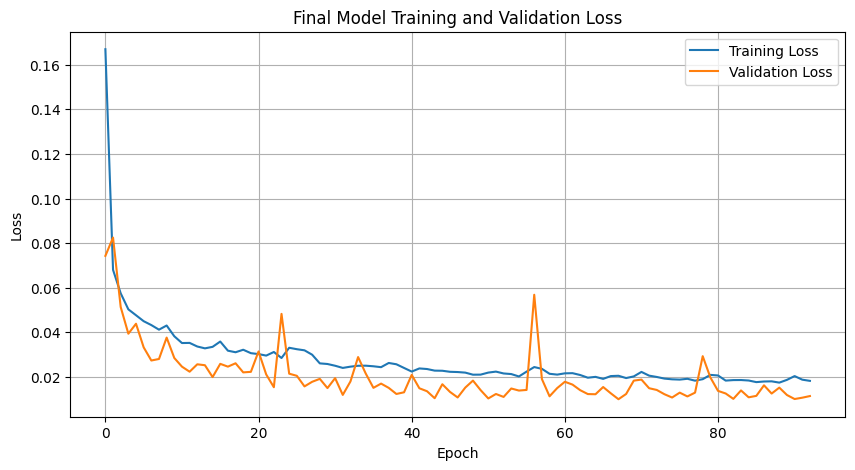

Best validation loss during final training: 0.009998
Final model saved to final_gnn_model.pth


In [499]:
# Load best_params if not in current session (e.g. after restarting kernel)
import json
try:
    with open('best_gnn_params.json', 'r') as f:
        best_params = json.load(f)
    print("Loaded best hyperparameters from file:", best_params)
except FileNotFoundError:
    print("best_gnn_params.json not found, using Optuna results from current session or defaults.")
    # best_params might already be defined if Optuna ran in the same session.
    # If not, you might need to define default_best_params or re-run Optuna.
    if 'best_params' not in globals():
        # Fallback to some reasonable defaults if Optuna didn't run or file not found
        best_params = { 
            'hidden_channels': 128, 'num_layers': 3, 'dropout': 0.2,
            'learning_rate': 1e-3, 'weight_decay': 1e-5, 'batch_size': 64
        }
        print("Using default fallback hyperparameters.")


# Train the model with best hyperparameters
# model_in_channels and model_out_channels should be defined from previous cells
# sequence_length, num_engineered_features, prediction_horizon

final_model = ImprovedGNNPredictor(
    in_channels=model_in_channels, 
    hidden_channels=best_params['hidden_channels'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout'],
    out_channels=model_out_channels
)

# Ensure train_dataset, val_dataset are correctly defined from gnn_dataset
train_loader_final = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, num_workers=2, pin_memory=True)
val_loader_final = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False, num_workers=2, pin_memory=True)

# Train the model using our enhanced training function
# Use learning_rate and weight_decay from best_params
train_losses, val_losses, best_val_loss_final = train_model(
    final_model, 
    train_loader_final, 
    val_loader_final, 
    epochs=200, # Increased epochs for final training
    patience=25, # Increased patience for final training
    learning_rate=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

# Visualize training progress
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Final Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f"Best validation loss during final training: {best_val_loss_final:.6f}")

# Save the final model
torch.save(final_model.state_dict(), 'final_gnn_model.pth')
print("Final model saved to final_gnn_model.pth")

Overall Test Metrics (on 101 samples):
RMSE: 1338.76
MAE: 462.08
MAPE: 2.50%
R2 Score: 0.6394


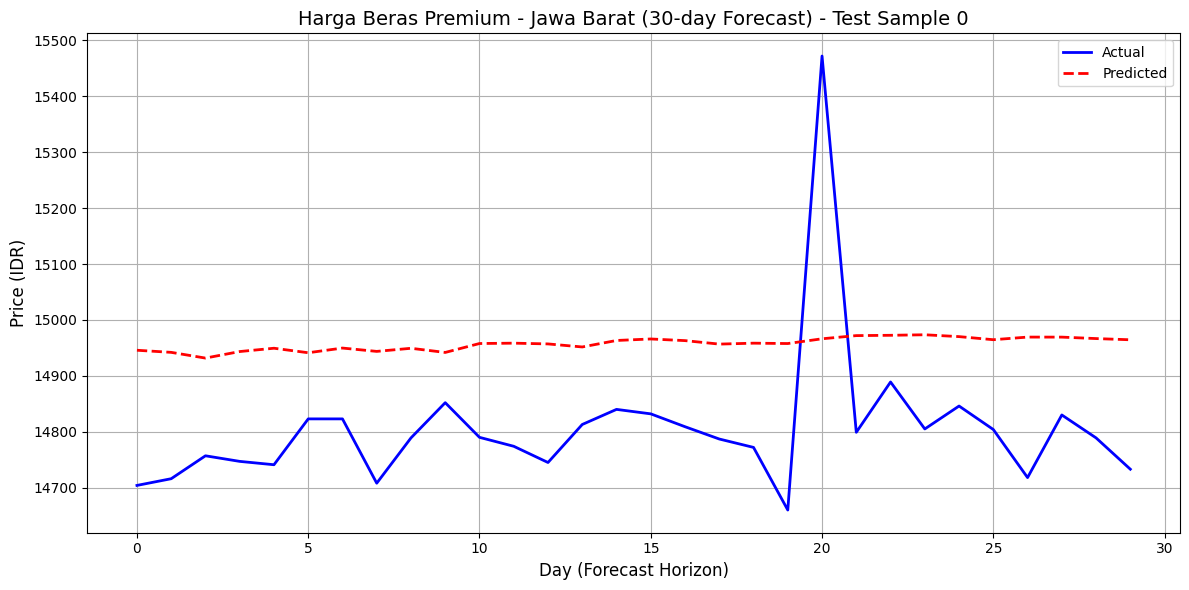

In [500]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Ensure DataLoader is imported if not already: from torch_geometric.data import DataLoader

# Load the model if not already in memory or for later use
# model_in_channels, model_out_channels, best_params should be available
# If running this cell independently, ensure these are loaded/defined.
# For example:
# with open('best_gnn_params.json', 'r') as f: best_params = json.load(f)
# model_to_evaluate = ImprovedGNNPredictor(in_channels=model_in_channels, ...)
# model_to_evaluate.load_state_dict(torch.load('final_gnn_model.pth'))

model_to_evaluate = final_model # Assuming final_model is the trained model from previous cell
model_to_evaluate.eval()

all_y_true_unscaled_list = []
all_y_pred_unscaled_list = []

# Use the test_dataset defined earlier
# test_dataset = gnn_dataset[split_val_gnn:]
test_loader = DataLoader(test_dataset, batch_size=best_params.get('batch_size', 64), shuffle=False)


with torch.no_grad():
    for batch_data in test_loader: # Iterate through batches from DataLoader
        # Assuming batch_data.x and batch_data.edge_index are on CPU
        # If model/data is on GPU, ensure batch_data is moved to the correct device
        # batch_data.x shape: (num_nodes_in_batch, model_in_channels)
        # batch_data.y shape: (num_nodes_in_batch, model_out_channels)
        
        pred_scaled_batch = model_to_evaluate(batch_data.x, batch_data.edge_index) # Shape: (num_nodes_in_batch, model_out_channels)
        
        y_true_batch_scaled_np = batch_data.y.cpu().numpy()
        pred_batch_scaled_np = pred_scaled_batch.cpu().numpy()

        # Unscale predictions and true values
        # We need to map nodes in the batch back to their original province index to use the correct scaler.
        # The DataLoader for GNNs with PyG typically preserves node identity if samples are graphs.
        # Here, each 'Data' object in gnn_dataset corresponds to one time snapshot for ALL provinces.
        # So, batch_data.x is effectively (num_provinces_in_snapshot * batch_size_of_snapshots, features) if batching snapshots.
        # However, our current DataLoader setup with `Data(x=(N,F), y=(N,O))` means a batch contains multiple `Data` objects.
        # Let's revert to iterating sample by sample for evaluation clarity if batch unscaling is complex.
        # The original code iterated sample by sample from test_dataset, which is simpler for unscaling.
        
        # Reverting to sample-by-sample evaluation for clarity with scalers
        # This part is similar to the original but ensures scalers_province_feature is used.
        
        start_idx = 0
        for i in range(batch_data.num_graphs): # num_graphs is batch size for graph-level tasks
            num_nodes_in_graph = gnn_dataset[0].num_nodes # Assuming all graphs (snapshots) have same num_nodes
            
            y_true_single_graph_scaled = y_true_batch_scaled_np[start_idx : start_idx + num_nodes_in_graph]
            pred_single_graph_scaled = pred_batch_scaled_np[start_idx : start_idx + num_nodes_in_graph]
            start_idx += num_nodes_in_graph

            y_true_sample_unscaled = np.zeros_like(y_true_single_graph_scaled) # (num_provinces, 30)
            y_pred_sample_unscaled = np.zeros_like(pred_single_graph_scaled) # (num_provinces, 30)

            for prov_idx in range(num_nodes_in_graph): # num_nodes_in_graph is num_provinces
                # Unscale using the scaler for the 'Harga' feature (index 0)
                scaler_for_price = scalers_province_feature[prov_idx][0] 
                
                y_true_sample_unscaled[prov_idx, :] = scaler_for_price.inverse_transform(
                    y_true_single_graph_scaled[prov_idx, :].reshape(1, -1)
                ).flatten()
                y_pred_sample_unscaled[prov_idx, :] = scaler_for_price.inverse_transform(
                    pred_single_graph_scaled[prov_idx, :].reshape(1, -1)
                ).flatten()
            
            all_y_true_unscaled_list.append(y_true_sample_unscaled)
            all_y_pred_unscaled_list.append(y_pred_sample_unscaled)


if all_y_true_unscaled_list:
    # y_true_agg / y_pred_agg will be list of arrays, each (num_provinces, 30)
    # Concatenate along the sample dimension (axis=0 of the list items)
    # then flatten for metrics, or calculate per-province metrics.
    
    # To get (total_samples * num_provinces, 30)
    y_true_all_samples_provinces = np.concatenate([item for item in all_y_true_unscaled_list], axis=0)
    y_pred_all_samples_provinces = np.concatenate([item for item in all_y_pred_unscaled_list], axis=0)

    y_true_flat = y_true_all_samples_provinces.flatten()
    y_pred_flat = y_pred_all_samples_provinces.flatten()

    rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    mape = np.mean(np.abs((y_true_flat - y_pred_flat) / (y_true_flat + 1e-9))) * 100 
    r2 = r2_score(y_true_flat, y_pred_flat)

    print(f"Overall Test Metrics (on {len(test_dataset)} samples):")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R2 Score: {r2:.4f}")

    # Visualization for a specific province from the first test sample
    if len(all_y_true_unscaled_list) > 0:
        y_true_vis_sample0 = all_y_true_unscaled_list[0] 
        y_pred_vis_sample0 = all_y_pred_unscaled_list[0]

        prov_to_visualize = 'Jawa Barat' 
        if prov_to_visualize in provinsi_to_index:
            prov_idx_vis = provinsi_to_index[prov_to_visualize]
            
            if prov_idx_vis < y_true_vis_sample0.shape[0]:
                actual_vis = y_true_vis_sample0[prov_idx_vis, :]
                predicted_vis = y_pred_vis_sample0[prov_idx_vis, :]

                plt.figure(figsize=(12, 6))
                plt.plot(actual_vis, 'b-', label='Actual', linewidth=2)
                plt.plot(predicted_vis, 'r--', label='Predicted', linewidth=2)
                plt.title(f'Harga Beras Premium - {prov_to_visualize} (30-day Forecast) - Test Sample 0', fontsize=14)
                plt.xlabel('Day (Forecast Horizon)', fontsize=12)
                plt.ylabel('Price (IDR)', fontsize=12)
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()
            else:
                print(f"Province index {prov_idx_vis} for '{prov_to_visualize}' is out of bounds for visualization sample.")
        else:
            print(f"Province '{prov_to_visualize}' not found in provinsi_to_index for visualization.")
else:
    print("No test data to evaluate or visualize.")

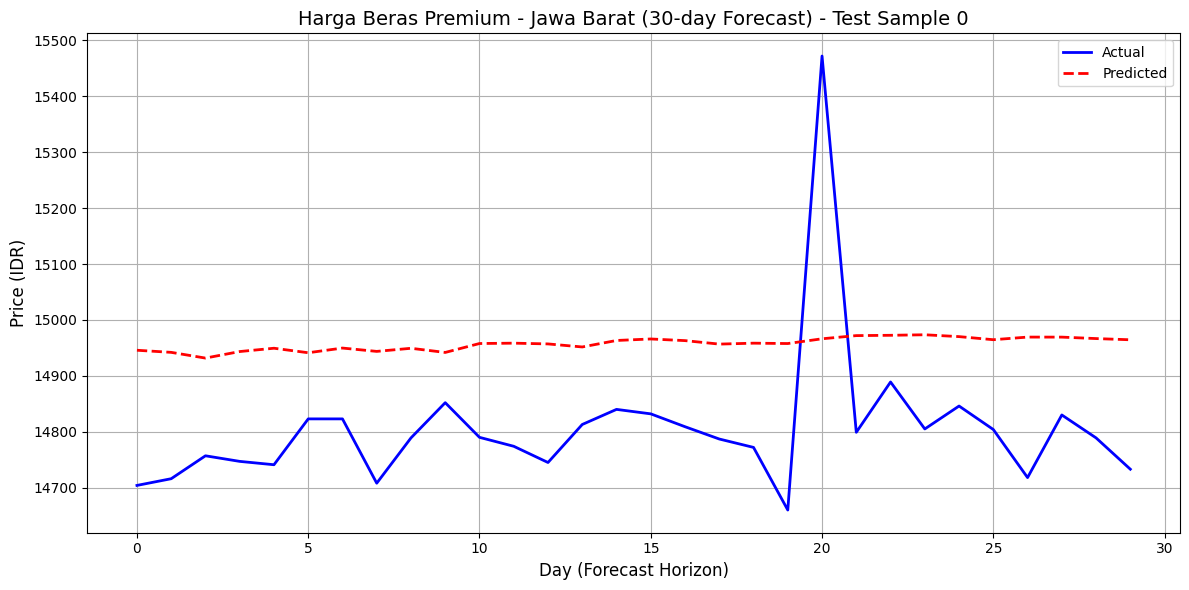

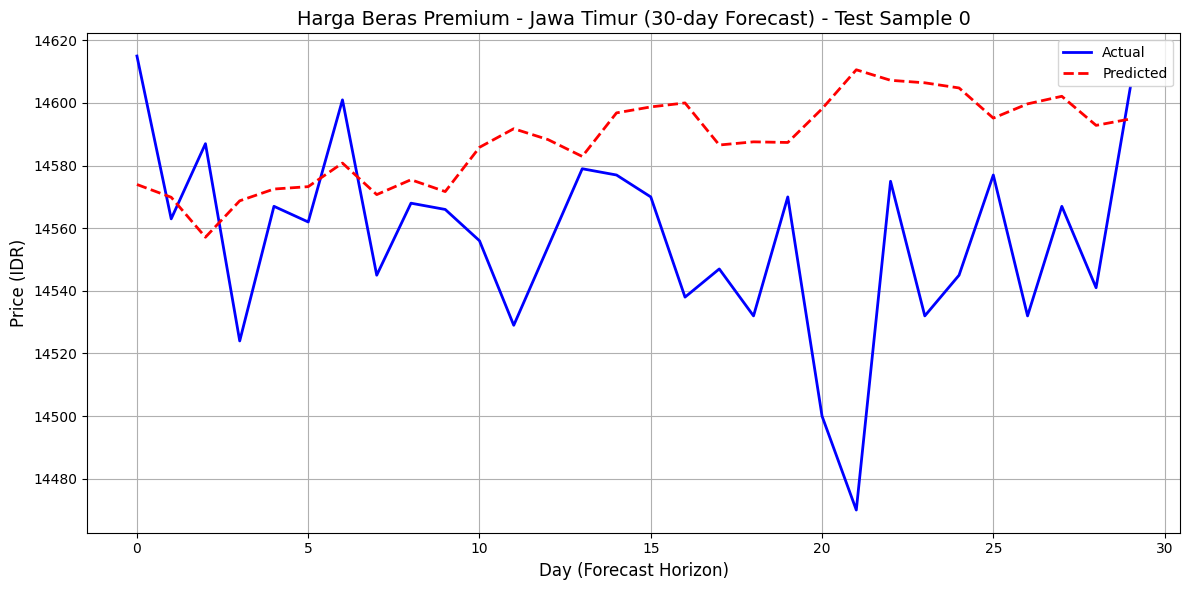

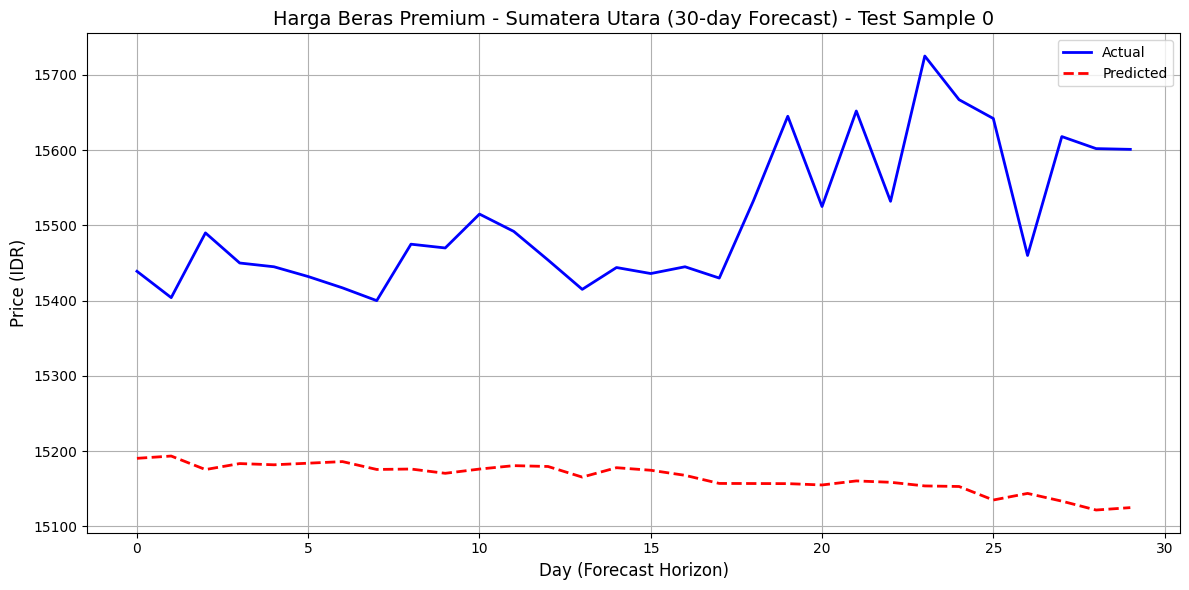

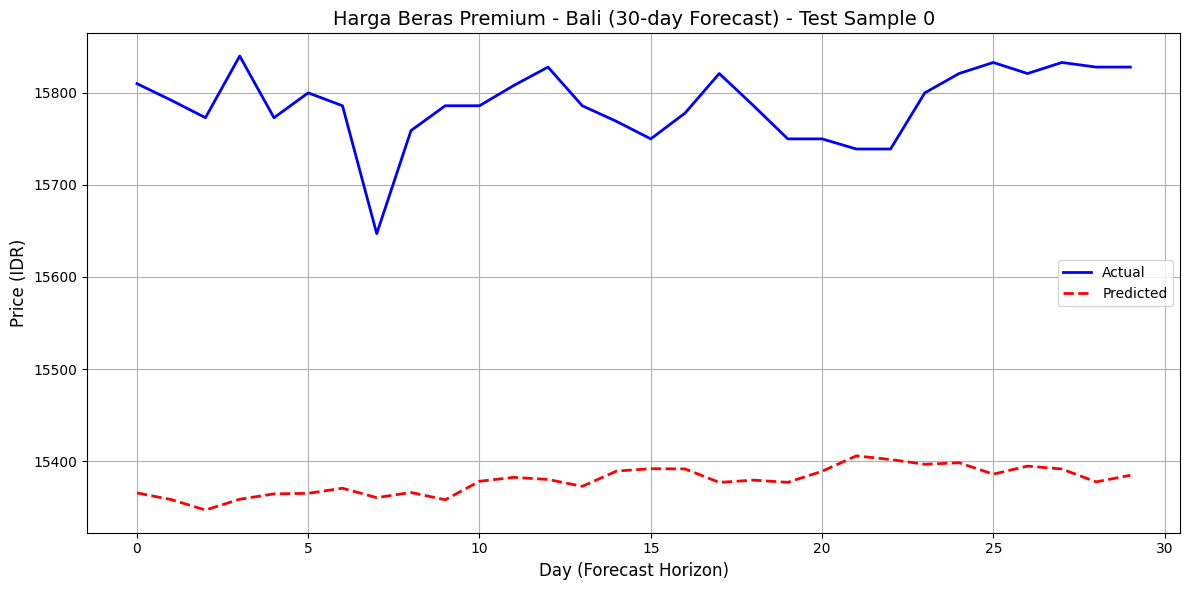

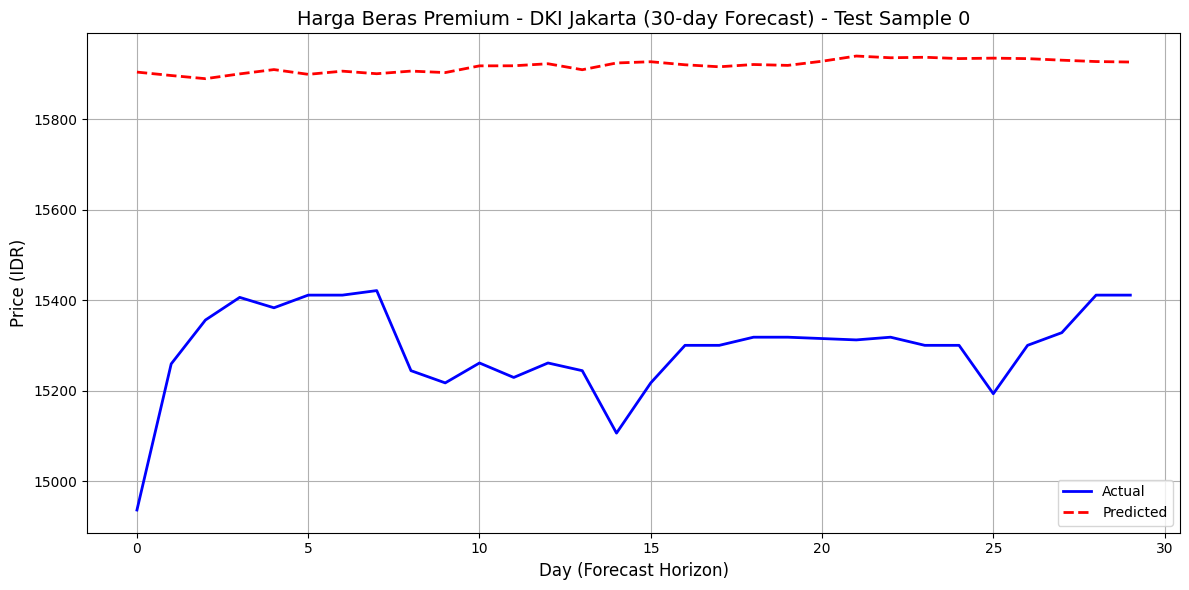

In [501]:
# Plot predictions for multiple provinces from the first test sample
if all_y_true_unscaled_list: 
    y_true_vis_sample0_multi = all_y_true_unscaled_list[0] 
    y_pred_vis_sample0_multi = all_y_pred_unscaled_list[0]

    provinces_to_plot_multi = ['Jawa Barat','Jawa Timur','Sumatera Utara','Bali', 'DKI Jakarta']
    for prov_name_multi in provinces_to_plot_multi:
        if prov_name_multi in provinsi_to_index:
            prov_idx_multi = provinsi_to_index[prov_name_multi]
            if prov_idx_multi < y_true_vis_sample0_multi.shape[0]:
                actual_multi = y_true_vis_sample0_multi[prov_idx_multi, :]
                predicted_multi = y_pred_vis_sample0_multi[prov_idx_multi, :]

                plt.figure(figsize=(12, 6))
                plt.plot(actual_multi, 'b-', label='Actual', linewidth=2)
                plt.plot(predicted_multi, 'r--', label='Predicted', linewidth=2)
                plt.title(f'Harga Beras Premium - {prov_name_multi} (30-day Forecast) - Test Sample 0', fontsize=14)
                plt.xlabel('Day (Forecast Horizon)', fontsize=12)
                plt.ylabel('Price (IDR)', fontsize=12)
                plt.legend()
                plt.grid(True)
                plt.tight_layout()
                plt.show()
            else:
                print(f"Province index {prov_idx_multi} for '{prov_name_multi}' is out of bounds for visualization sample.")
        else:
            print(f"Province '{prov_name_multi}' not found in provinsi_to_index for plotting.")
else:
    print("No test data available for plotting multiple provinces.")